# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-random-kfold'
epochs = 10
batch_size = 64
sequence_length = 80
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)
label_columns = data.columns[1:]

# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        # This print can be commented out to reduce log spam in a k-fold loop
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    if len(remaining_indices) < n_samples:
        random_indices = range(len(X_pool))
    else:
        random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train_fold[i] for i in temp],
            'HS': [y_train_fold[i][0] for i in temp],
            'Abusive': [y_train_fold[i][1] for i in temp],
            'HS_Individual': [y_train_fold[i][2] for i in temp],
            'HS_Group': [y_train_fold[i][3] for i in temp],
            'HS_Religion': [y_train_fold[i][4] for i in temp],
            'HS_Race': [y_train_fold[i][5] for i in temp],
            'HS_Physical': [y_train_fold[i][6] for i in temp],
            'HS_Gender': [y_train_fold[i][7] for i in temp],
            'HS_Other': [y_train_fold[i][8] for i in temp],
            'HS_Weak': [y_train_fold[i][9] for i in temp],
            'HS_Moderate': [y_train_fold[i][10] for i in temp],
            'HS_Strong': [y_train_fold[i][11] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
from sklearn.model_selection import KFold

N_SPLITS = 5 
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[1:]
X = data['Tweet'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Each element in these lists will be a list of metrics for one fold's learning curve
all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("===============================================")
    print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
    print("===============================================")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Shared resources for this fold's processes
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    
    set_seed(RANDOM_SEED + fold)
    
    # Define the initial labeled pool from the current fold's training data
    total_train_fold_size = len(X_train_fold) + len(X_val_fold)
    initial_train_size = int(0.05 * total_train_fold_size)
    
    train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
    current_train_size = initial_train_size

    # Adjust checkpoints based on the current fold's training size
    checkpoints = [
        int(0.5 * total_train_fold_size), 
        int(0.6 * total_train_fold_size),
        int(0.7 * total_train_fold_size),
        len(X_train_fold)
    ]
    
    fold_start_time = time.time()
    
    while current_train_size < total_train_fold_size:
        # 1. Train the model on the current labeled set
        train_args = (
            current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
            fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
        )
        notebook_launcher(train_model, train_args, num_processes=2)
        
        # Stop if we've reached the last checkpoint
        if current_train_size >= checkpoints[-1]:
            break
        
        # 3. Perform query strategy to select new samples
        new_samples_shared = manager.list()
        X_pool = [X_train_fold[i] for i in remaining_indices]
        random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples_shared, fold, X_train_fold, y_train_fold)
        
        # 4. Update the pools
        newly_acquired_indices = list(new_samples_shared)
        train_indices.extend(newly_acquired_indices)
        remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
    
        current_train_size = len(train_indices)
        print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
    
    fold_end_time = time.time()
    print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
    # Store the results for this fold
    all_fold_data_used.append(list(data_used))
    all_fold_accuracies.append(list(accuracies))
    all_fold_f1_micros.append(list(f1_micros))
    all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 658 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6381, Accuracy: 0.7985, F1 Micro: 0.3882, F1 Macro: 0.1172
Epoch 2/10, Train Loss: 0.4768, Accuracy: 0.8343, F1 Micro: 0.1455, F1 Macro: 0.0462
Epoch 3/10, Train Loss: 0.4068, Accuracy: 0.8333, F1 Micro: 0.1123, F1 Macro: 0.0388
Epoch 4/10, Train Loss: 0.3813, Accuracy: 0.8332, F1 Micro: 0.1021, F1 Macro: 0.0367
Epoch 5/10, Train Loss: 0.3774, Accuracy: 0.8373, F1 Micro: 0.1641, F1 Macro: 0.0541
Epoch 6/10, Train Loss: 0.3665, Accuracy: 0.844, F1 Micro: 0.2355, F1 Macro: 0.0791
Epoch 7/10, Train Loss: 0.355, Accuracy: 0.8526, F1 Micro: 0.3214, F1 Macro: 0.1069
Epoch 8/10, Train Loss: 0.3289, Accuracy: 0.8608, F1 Micro: 0.3921, F1 Macro: 0.1407
Epoch 9/10, Train Loss: 0.3142, Accuracy: 0.871, F1 Micro: 0.4906, F1 Macro: 0.2141
Epoch 10/10, Train Loss: 0.2951, Accuracy: 0.8741, F1 Micro: 0.5196, F1 Macro: 0.2373
Best result for 658 samples: F1 Micro: 0.5196
               precision    recall  f1-score   support

           HS       0.84      0.61      0.71      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5506, Accuracy: 0.8305, F1 Micro: 0.0748, F1 Macro: 0.0283
Epoch 2/10, Train Loss: 0.4025, Accuracy: 0.8305, F1 Micro: 0.0579, F1 Macro: 0.0232
Epoch 3/10, Train Loss: 0.3704, Accuracy: 0.8371, F1 Micro: 0.1401, F1 Macro: 0.0496
Epoch 4/10, Train Loss: 0.3403, Accuracy: 0.864, F1 Micro: 0.4243, F1 Macro: 0.1621
Epoch 5/10, Train Loss: 0.3101, Accuracy: 0.8796, F1 Micro: 0.5683, F1 Macro: 0.2728
Epoch 6/10, Train Loss: 0.2746, Accuracy: 0.8866, F1 Micro: 0.6074, F1 Macro: 0.3192
Epoch 7/10, Train Loss: 0.251, Accuracy: 0.8902, F1 Micro: 0.6275, F1 Macro: 0.3793
Epoch 8/10, Train Loss: 0.2197, Accuracy: 0.8936, F1 Micro: 0.6346, F1 Macro: 0.4135
Epoch 9/10, Train Loss: 0.2055, Accuracy: 0.8965, F1 Micro: 0.682, F1 Macro: 0.4801
Epoch 10/10, Train Loss: 0.188, Accuracy: 0.8985, F1 Micro: 0.6783, F1 Macro: 0.4768
Best result for 1646 samples: F1 Micro: 0.682
               precision    recall  f1-score   support

           HS       0.81      0.81      0.81      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5009, Accuracy: 0.8316, F1 Micro: 0.0784, F1 Macro: 0.0301
Epoch 2/10, Train Loss: 0.3813, Accuracy: 0.8497, F1 Micro: 0.2762, F1 Macro: 0.0951
Epoch 3/10, Train Loss: 0.3362, Accuracy: 0.8801, F1 Micro: 0.5879, F1 Macro: 0.2757
Epoch 4/10, Train Loss: 0.294, Accuracy: 0.8859, F1 Micro: 0.5936, F1 Macro: 0.2942
Epoch 5/10, Train Loss: 0.2532, Accuracy: 0.8967, F1 Micro: 0.6806, F1 Macro: 0.4658
Epoch 6/10, Train Loss: 0.2265, Accuracy: 0.899, F1 Micro: 0.6941, F1 Macro: 0.4816
Epoch 7/10, Train Loss: 0.1973, Accuracy: 0.897, F1 Micro: 0.6338, F1 Macro: 0.4532
Epoch 8/10, Train Loss: 0.18, Accuracy: 0.9036, F1 Micro: 0.6864, F1 Macro: 0.4783
Epoch 9/10, Train Loss: 0.1589, Accuracy: 0.9057, F1 Micro: 0.7177, F1 Macro: 0.5523
Epoch 10/10, Train Loss: 0.1409, Accuracy: 0.9062, F1 Micro: 0.7172, F1 Macro: 0.519
Best result for 2535 samples: F1 Micro: 0.7177
               precision    recall  f1-score   support

           HS       0.83      0.82      0.82      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4758, Accuracy: 0.8331, F1 Micro: 0.0918, F1 Macro: 0.0357
Epoch 2/10, Train Loss: 0.3574, Accuracy: 0.8661, F1 Micro: 0.4298, F1 Macro: 0.1818
Epoch 3/10, Train Loss: 0.2982, Accuracy: 0.886, F1 Micro: 0.6052, F1 Macro: 0.2937
Epoch 4/10, Train Loss: 0.2603, Accuracy: 0.8946, F1 Micro: 0.6972, F1 Macro: 0.4489
Epoch 5/10, Train Loss: 0.2249, Accuracy: 0.9023, F1 Micro: 0.7008, F1 Macro: 0.4992
Epoch 6/10, Train Loss: 0.1935, Accuracy: 0.9053, F1 Micro: 0.7017, F1 Macro: 0.5043
Epoch 7/10, Train Loss: 0.1786, Accuracy: 0.9069, F1 Micro: 0.7249, F1 Macro: 0.5541
Epoch 8/10, Train Loss: 0.1524, Accuracy: 0.909, F1 Micro: 0.7131, F1 Macro: 0.5236
Epoch 9/10, Train Loss: 0.1322, Accuracy: 0.9107, F1 Micro: 0.7185, F1 Macro: 0.5602
Epoch 10/10, Train Loss: 0.1165, Accuracy: 0.9076, F1 Micro: 0.7195, F1 Macro: 0.572
Best result for 3335 samples: F1 Micro: 0.7249
               precision    recall  f1-score   support

           HS       0.82      0.84      0.83     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.457, Accuracy: 0.8369, F1 Micro: 0.1397, F1 Macro: 0.0513
Epoch 2/10, Train Loss: 0.3431, Accuracy: 0.8784, F1 Micro: 0.5437, F1 Macro: 0.256
Epoch 3/10, Train Loss: 0.2837, Accuracy: 0.8963, F1 Micro: 0.6652, F1 Macro: 0.4091
Epoch 4/10, Train Loss: 0.2449, Accuracy: 0.8974, F1 Micro: 0.6378, F1 Macro: 0.4639
Epoch 5/10, Train Loss: 0.2134, Accuracy: 0.9063, F1 Micro: 0.6931, F1 Macro: 0.5049
Epoch 6/10, Train Loss: 0.1883, Accuracy: 0.9089, F1 Micro: 0.7319, F1 Macro: 0.5514
Epoch 7/10, Train Loss: 0.1615, Accuracy: 0.9134, F1 Micro: 0.7445, F1 Macro: 0.5772
Epoch 8/10, Train Loss: 0.1433, Accuracy: 0.9146, F1 Micro: 0.7385, F1 Macro: 0.5788
Epoch 9/10, Train Loss: 0.1248, Accuracy: 0.912, F1 Micro: 0.7322, F1 Macro: 0.5444
Epoch 10/10, Train Loss: 0.1103, Accuracy: 0.917, F1 Micro: 0.7501, F1 Macro: 0.5914
Best result for 4055 samples: F1 Micro: 0.7501
               precision    recall  f1-score   support

           HS       0.87      0.82      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4482, Accuracy: 0.8464, F1 Micro: 0.241, F1 Macro: 0.0853
Epoch 2/10, Train Loss: 0.3296, Accuracy: 0.8848, F1 Micro: 0.6073, F1 Macro: 0.296
Epoch 3/10, Train Loss: 0.2661, Accuracy: 0.9003, F1 Micro: 0.6682, F1 Macro: 0.4425
Epoch 4/10, Train Loss: 0.2248, Accuracy: 0.9063, F1 Micro: 0.7187, F1 Macro: 0.5243
Epoch 5/10, Train Loss: 0.1986, Accuracy: 0.9092, F1 Micro: 0.6985, F1 Macro: 0.5102
Epoch 6/10, Train Loss: 0.1738, Accuracy: 0.9122, F1 Micro: 0.717, F1 Macro: 0.5507
Epoch 7/10, Train Loss: 0.1485, Accuracy: 0.9097, F1 Micro: 0.7456, F1 Macro: 0.5873
Epoch 8/10, Train Loss: 0.1296, Accuracy: 0.9146, F1 Micro: 0.7442, F1 Macro: 0.5832
Epoch 9/10, Train Loss: 0.1099, Accuracy: 0.9183, F1 Micro: 0.7506, F1 Macro: 0.6023
Epoch 10/10, Train Loss: 0.0921, Accuracy: 0.916, F1 Micro: 0.7437, F1 Macro: 0.5907
Best result for 4703 samples: F1 Micro: 0.7506
               precision    recall  f1-score   support

           HS       0.87      0.81      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4377, Accuracy: 0.858, F1 Micro: 0.3929, F1 Macro: 0.1219
Epoch 2/10, Train Loss: 0.315, Accuracy: 0.884, F1 Micro: 0.5677, F1 Macro: 0.2869
Epoch 3/10, Train Loss: 0.251, Accuracy: 0.9025, F1 Micro: 0.6764, F1 Macro: 0.452
Epoch 4/10, Train Loss: 0.2149, Accuracy: 0.9088, F1 Micro: 0.7308, F1 Macro: 0.5391
Epoch 5/10, Train Loss: 0.183, Accuracy: 0.9152, F1 Micro: 0.7408, F1 Macro: 0.5711
Epoch 6/10, Train Loss: 0.1583, Accuracy: 0.9149, F1 Micro: 0.7507, F1 Macro: 0.5852
Epoch 7/10, Train Loss: 0.1411, Accuracy: 0.9175, F1 Micro: 0.749, F1 Macro: 0.5989
Epoch 8/10, Train Loss: 0.119, Accuracy: 0.9151, F1 Micro: 0.7607, F1 Macro: 0.6112
Epoch 9/10, Train Loss: 0.1018, Accuracy: 0.9173, F1 Micro: 0.7632, F1 Macro: 0.613
Epoch 10/10, Train Loss: 0.0882, Accuracy: 0.9219, F1 Micro: 0.7683, F1 Macro: 0.633
Best result for 5287 samples: F1 Micro: 0.7683
               precision    recall  f1-score   support

           HS       0.86      0.84      0.85      1141
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4336, Accuracy: 0.8592, F1 Micro: 0.3789, F1 Macro: 0.1314
Epoch 2/10, Train Loss: 0.3053, Accuracy: 0.8912, F1 Micro: 0.6176, F1 Macro: 0.3546
Epoch 3/10, Train Loss: 0.251, Accuracy: 0.9067, F1 Micro: 0.7104, F1 Macro: 0.5013
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.9092, F1 Micro: 0.6992, F1 Macro: 0.5087
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9157, F1 Micro: 0.7407, F1 Macro: 0.5417
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9194, F1 Micro: 0.748, F1 Macro: 0.5662
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.9189, F1 Micro: 0.7644, F1 Macro: 0.6022
Epoch 8/10, Train Loss: 0.1148, Accuracy: 0.9207, F1 Micro: 0.7647, F1 Macro: 0.6074
Epoch 9/10, Train Loss: 0.0992, Accuracy: 0.9179, F1 Micro: 0.7625, F1 Macro: 0.6111
Epoch 10/10, Train Loss: 0.0844, Accuracy: 0.9186, F1 Micro: 0.7633, F1 Macro: 0.6358
Best result for 5812 samples: F1 Micro: 0.7647
               precision    recall  f1-score   support

           HS       0.86      0.85      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4249, Accuracy: 0.8652, F1 Micro: 0.4312, F1 Macro: 0.1729
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.8972, F1 Micro: 0.6629, F1 Macro: 0.3832
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.9057, F1 Micro: 0.6925, F1 Macro: 0.5151
Epoch 4/10, Train Loss: 0.21, Accuracy: 0.9112, F1 Micro: 0.7199, F1 Macro: 0.5044
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9173, F1 Micro: 0.7569, F1 Macro: 0.5936
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.9174, F1 Micro: 0.7621, F1 Macro: 0.6091
Epoch 7/10, Train Loss: 0.1307, Accuracy: 0.9209, F1 Micro: 0.7658, F1 Macro: 0.6153
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9199, F1 Micro: 0.7649, F1 Macro: 0.6354
Epoch 9/10, Train Loss: 0.0934, Accuracy: 0.9213, F1 Micro: 0.7669, F1 Macro: 0.6406
Epoch 10/10, Train Loss: 0.0803, Accuracy: 0.921, F1 Micro: 0.7684, F1 Macro: 0.6568
Best result for 6285 samples: F1 Micro: 0.7684
               precision    recall  f1-score   support

           HS       0.85      0.84      0.85      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4227, Accuracy: 0.8622, F1 Micro: 0.3957, F1 Macro: 0.1612
Epoch 2/10, Train Loss: 0.295, Accuracy: 0.8905, F1 Micro: 0.6041, F1 Macro: 0.3483
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.9094, F1 Micro: 0.7233, F1 Macro: 0.5265
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9151, F1 Micro: 0.7414, F1 Macro: 0.5559
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.9179, F1 Micro: 0.7574, F1 Macro: 0.5986
Epoch 6/10, Train Loss: 0.1465, Accuracy: 0.9123, F1 Micro: 0.7549, F1 Macro: 0.6023
Epoch 7/10, Train Loss: 0.1272, Accuracy: 0.9212, F1 Micro: 0.7627, F1 Macro: 0.6172
Epoch 8/10, Train Loss: 0.1102, Accuracy: 0.9182, F1 Micro: 0.7624, F1 Macro: 0.6238
Epoch 9/10, Train Loss: 0.0955, Accuracy: 0.9187, F1 Micro: 0.764, F1 Macro: 0.646
Epoch 10/10, Train Loss: 0.0785, Accuracy: 0.9201, F1 Micro: 0.7585, F1 Macro: 0.6495
Best result for 6584 samples: F1 Micro: 0.764
               precision    recall  f1-score   support

           HS       0.84      0.85      0.84      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8729, F1 Micro: 0.5008, F1 Macro: 0.2165
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.8981, F1 Micro: 0.6517, F1 Macro: 0.3992
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9092, F1 Micro: 0.7332, F1 Macro: 0.5303
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.9159, F1 Micro: 0.744, F1 Macro: 0.5623
Epoch 5/10, Train Loss: 0.1696, Accuracy: 0.9194, F1 Micro: 0.7564, F1 Macro: 0.5874
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9201, F1 Micro: 0.7659, F1 Macro: 0.6034
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9173, F1 Micro: 0.7646, F1 Macro: 0.6111
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9227, F1 Micro: 0.771, F1 Macro: 0.6199
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.9218, F1 Micro: 0.7713, F1 Macro: 0.6298
Epoch 10/10, Train Loss: 0.0781, Accuracy: 0.9228, F1 Micro: 0.7686, F1 Macro: 0.6514
Best result for 6980 samples: F1 Micro: 0.7713
               precision    recall  f1-score   support

           HS       0.84      0.86      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4124, Accuracy: 0.879, F1 Micro: 0.5734, F1 Macro: 0.2638
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.9047, F1 Micro: 0.7002, F1 Macro: 0.4835
Epoch 3/10, Train Loss: 0.2318, Accuracy: 0.9113, F1 Micro: 0.736, F1 Macro: 0.5448
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9184, F1 Micro: 0.7463, F1 Macro: 0.5847
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9191, F1 Micro: 0.7626, F1 Macro: 0.6125
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9197, F1 Micro: 0.7685, F1 Macro: 0.6177
Epoch 7/10, Train Loss: 0.1184, Accuracy: 0.9148, F1 Micro: 0.7629, F1 Macro: 0.6138
Epoch 8/10, Train Loss: 0.0986, Accuracy: 0.9227, F1 Micro: 0.7733, F1 Macro: 0.6444
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9205, F1 Micro: 0.7658, F1 Macro: 0.6365
Epoch 10/10, Train Loss: 0.0754, Accuracy: 0.9237, F1 Micro: 0.768, F1 Macro: 0.6424
Best result for 7336 samples: F1 Micro: 0.7733
               precision    recall  f1-score   support

           HS       0.85      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4072, Accuracy: 0.8785, F1 Micro: 0.5594, F1 Macro: 0.2578
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.9026, F1 Micro: 0.7031, F1 Macro: 0.4803
Epoch 3/10, Train Loss: 0.2316, Accuracy: 0.911, F1 Micro: 0.7312, F1 Macro: 0.531
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.917, F1 Micro: 0.7615, F1 Macro: 0.5997
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9216, F1 Micro: 0.7648, F1 Macro: 0.6089
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9218, F1 Micro: 0.7713, F1 Macro: 0.6142
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9218, F1 Micro: 0.7711, F1 Macro: 0.625
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9219, F1 Micro: 0.7704, F1 Macro: 0.6459
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9235, F1 Micro: 0.772, F1 Macro: 0.664
Epoch 10/10, Train Loss: 0.0738, Accuracy: 0.9239, F1 Micro: 0.7789, F1 Macro: 0.6687
Best result for 7656 samples: F1 Micro: 0.7789
               precision    recall  f1-score   support

           HS       0.84      0.86      0.85      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4082, Accuracy: 0.8793, F1 Micro: 0.552, F1 Macro: 0.2589
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.902, F1 Micro: 0.7047, F1 Macro: 0.5007
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.9139, F1 Micro: 0.7371, F1 Macro: 0.562
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.9179, F1 Micro: 0.7351, F1 Macro: 0.5473
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9202, F1 Micro: 0.7647, F1 Macro: 0.6065
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9212, F1 Micro: 0.7724, F1 Macro: 0.6266
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9215, F1 Micro: 0.7618, F1 Macro: 0.6016
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.9201, F1 Micro: 0.7714, F1 Macro: 0.6408
Epoch 9/10, Train Loss: 0.0882, Accuracy: 0.9227, F1 Micro: 0.7729, F1 Macro: 0.6501
Epoch 10/10, Train Loss: 0.0778, Accuracy: 0.9229, F1 Micro: 0.7701, F1 Macro: 0.6497
Best result for 7901 samples: F1 Micro: 0.7729
               precision    recall  f1-score   support

           HS       0.85      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4015, Accuracy: 0.8789, F1 Micro: 0.5425, F1 Macro: 0.2518
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.904, F1 Micro: 0.6909, F1 Macro: 0.4355
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.913, F1 Micro: 0.7221, F1 Macro: 0.5316
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9196, F1 Micro: 0.7597, F1 Macro: 0.6003
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9225, F1 Micro: 0.7685, F1 Macro: 0.6124
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9213, F1 Micro: 0.7738, F1 Macro: 0.6247
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9231, F1 Micro: 0.7761, F1 Macro: 0.6583
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9217, F1 Micro: 0.7741, F1 Macro: 0.6456
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9257, F1 Micro: 0.7768, F1 Macro: 0.6645
Epoch 10/10, Train Loss: 0.0733, Accuracy: 0.9249, F1 Micro: 0.7788, F1 Macro: 0.6835
Best result for 8165 samples: F1 Micro: 0.7788
               precision    recall  f1-score   support

           HS       0.86      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4, Accuracy: 0.8817, F1 Micro: 0.5805, F1 Macro: 0.2796
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.9039, F1 Micro: 0.6749, F1 Macro: 0.4449
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9156, F1 Micro: 0.7442, F1 Macro: 0.5753
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.921, F1 Micro: 0.7594, F1 Macro: 0.598
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9223, F1 Micro: 0.7727, F1 Macro: 0.618
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9229, F1 Micro: 0.7799, F1 Macro: 0.6331
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9209, F1 Micro: 0.7772, F1 Macro: 0.6443
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9261, F1 Micro: 0.7738, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9227, F1 Micro: 0.7751, F1 Macro: 0.647
Epoch 10/10, Train Loss: 0.0709, Accuracy: 0.9219, F1 Micro: 0.7759, F1 Macro: 0.6752
Best result for 8402 samples: F1 Micro: 0.7799
               precision    recall  f1-score   support

           HS       0.84      0.89      0.86      1141


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3997, Accuracy: 0.8805, F1 Micro: 0.5618, F1 Macro: 0.2639
Epoch 2/10, Train Loss: 0.2755, Accuracy: 0.9042, F1 Micro: 0.7161, F1 Macro: 0.4965
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9134, F1 Micro: 0.7233, F1 Macro: 0.5271
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9204, F1 Micro: 0.7606, F1 Macro: 0.6031
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9229, F1 Micro: 0.764, F1 Macro: 0.6177
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9215, F1 Micro: 0.7743, F1 Macro: 0.6237
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9227, F1 Micro: 0.7739, F1 Macro: 0.6451
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9235, F1 Micro: 0.7737, F1 Macro: 0.6644
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9234, F1 Micro: 0.7742, F1 Macro: 0.6699
Epoch 10/10, Train Loss: 0.0724, Accuracy: 0.9234, F1 Micro: 0.7726, F1 Macro: 0.6799
Best result for 8616 samples: F1 Micro: 0.7743
               precision    recall  f1-score   support

           HS       0.83      0.88      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.398, Accuracy: 0.8828, F1 Micro: 0.5908, F1 Macro: 0.2792
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.9038, F1 Micro: 0.7201, F1 Macro: 0.4811
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9164, F1 Micro: 0.7473, F1 Macro: 0.5839
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9218, F1 Micro: 0.7677, F1 Macro: 0.577
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9237, F1 Micro: 0.7697, F1 Macro: 0.6187
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9246, F1 Micro: 0.7748, F1 Macro: 0.623
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9255, F1 Micro: 0.7781, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9213, F1 Micro: 0.7726, F1 Macro: 0.6628
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.924, F1 Micro: 0.7689, F1 Macro: 0.6666
Epoch 10/10, Train Loss: 0.0708, Accuracy: 0.9271, F1 Micro: 0.7803, F1 Macro: 0.6831
Best result for 8816 samples: F1 Micro: 0.7803
               precision    recall  f1-score   support

           HS       0.88      0.83      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8845, F1 Micro: 0.6078, F1 Macro: 0.2879
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.908, F1 Micro: 0.7189, F1 Macro: 0.5036
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.9182, F1 Micro: 0.7497, F1 Macro: 0.5722
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9203, F1 Micro: 0.767, F1 Macro: 0.6052
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9216, F1 Micro: 0.7737, F1 Macro: 0.6198
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9213, F1 Micro: 0.7746, F1 Macro: 0.6286
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9244, F1 Micro: 0.7755, F1 Macro: 0.6355
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9236, F1 Micro: 0.7733, F1 Macro: 0.6732
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9248, F1 Micro: 0.7811, F1 Macro: 0.6866
Epoch 10/10, Train Loss: 0.0693, Accuracy: 0.9245, F1 Micro: 0.7749, F1 Macro: 0.6829
Best result for 9016 samples: F1 Micro: 0.7811
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3951, Accuracy: 0.8801, F1 Micro: 0.5469, F1 Macro: 0.2568
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.9075, F1 Micro: 0.7064, F1 Macro: 0.5118
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9147, F1 Micro: 0.7483, F1 Macro: 0.5365
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9213, F1 Micro: 0.7512, F1 Macro: 0.5949
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.925, F1 Micro: 0.7695, F1 Macro: 0.6279
Epoch 6/10, Train Loss: 0.1304, Accuracy: 0.9233, F1 Micro: 0.7749, F1 Macro: 0.6261
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9244, F1 Micro: 0.7704, F1 Macro: 0.6476
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9249, F1 Micro: 0.7799, F1 Macro: 0.6917
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9215, F1 Micro: 0.7779, F1 Macro: 0.6852
Epoch 10/10, Train Loss: 0.0683, Accuracy: 0.9258, F1 Micro: 0.7785, F1 Macro: 0.6936
Best result for 9216 samples: F1 Micro: 0.7799
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8848, F1 Micro: 0.5981, F1 Macro: 0.2905
Epoch 2/10, Train Loss: 0.2613, Accuracy: 0.908, F1 Micro: 0.7077, F1 Macro: 0.4913
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.9181, F1 Micro: 0.7598, F1 Macro: 0.5945
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9226, F1 Micro: 0.7551, F1 Macro: 0.5935
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9219, F1 Micro: 0.7802, F1 Macro: 0.6247
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9247, F1 Micro: 0.781, F1 Macro: 0.6373
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9251, F1 Micro: 0.7828, F1 Macro: 0.6524
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9255, F1 Micro: 0.7785, F1 Macro: 0.679
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9241, F1 Micro: 0.7828, F1 Macro: 0.6614
Epoch 10/10, Train Loss: 0.0682, Accuracy: 0.9256, F1 Micro: 0.78, F1 Macro: 0.6921
Best result for 9218 samples: F1 Micro: 0.7828
               precision    recall  f1-score   support

           HS       0.83      0.89      0.86      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8845, F1 Micro: 0.5848, F1 Macro: 0.2894
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9057, F1 Micro: 0.7185, F1 Macro: 0.4704
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9142, F1 Micro: 0.7537, F1 Macro: 0.5882
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9231, F1 Micro: 0.7656, F1 Macro: 0.6073
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.925, F1 Micro: 0.7668, F1 Macro: 0.6231
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9252, F1 Micro: 0.7693, F1 Macro: 0.6286
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9233, F1 Micro: 0.7708, F1 Macro: 0.634
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9253, F1 Micro: 0.7858, F1 Macro: 0.6689
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9244, F1 Micro: 0.7776, F1 Macro: 0.6763
Epoch 10/10, Train Loss: 0.0667, Accuracy: 0.925, F1 Micro: 0.7792, F1 Macro: 0.6747
Best result for 9418 samples: F1 Micro: 0.7858
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8846, F1 Micro: 0.6018, F1 Macro: 0.2874
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.903, F1 Micro: 0.6604, F1 Macro: 0.4293
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.9198, F1 Micro: 0.7552, F1 Macro: 0.5777
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9235, F1 Micro: 0.7726, F1 Macro: 0.6152
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.924, F1 Micro: 0.7801, F1 Macro: 0.6454
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9233, F1 Micro: 0.7799, F1 Macro: 0.6575
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9264, F1 Micro: 0.7858, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9261, F1 Micro: 0.7814, F1 Macro: 0.678
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9266, F1 Micro: 0.7856, F1 Macro: 0.6899
Epoch 10/10, Train Loss: 0.0712, Accuracy: 0.9271, F1 Micro: 0.7868, F1 Macro: 0.7068
Best result for 9618 samples: F1 Micro: 0.7868
               precision    recall  f1-score   support

           HS       0.86      0.85      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8836, F1 Micro: 0.5718, F1 Macro: 0.2724
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.9105, F1 Micro: 0.718, F1 Macro: 0.489
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9195, F1 Micro: 0.7582, F1 Macro: 0.5888
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.922, F1 Micro: 0.7742, F1 Macro: 0.619
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9266, F1 Micro: 0.7835, F1 Macro: 0.6415
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9276, F1 Micro: 0.7834, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9246, F1 Micro: 0.7757, F1 Macro: 0.6483
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9254, F1 Micro: 0.7843, F1 Macro: 0.679
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9285, F1 Micro: 0.7842, F1 Macro: 0.6722
Epoch 10/10, Train Loss: 0.068, Accuracy: 0.9268, F1 Micro: 0.7869, F1 Macro: 0.7057
Best result for 9818 samples: F1 Micro: 0.7869
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      1141

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8866, F1 Micro: 0.6524, F1 Macro: 0.326
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9096, F1 Micro: 0.6988, F1 Macro: 0.4859
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.9199, F1 Micro: 0.7568, F1 Macro: 0.5834
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9242, F1 Micro: 0.7732, F1 Macro: 0.6205
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9258, F1 Micro: 0.7816, F1 Macro: 0.6439
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9269, F1 Micro: 0.7746, F1 Macro: 0.6245
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9276, F1 Micro: 0.7896, F1 Macro: 0.6539
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9274, F1 Micro: 0.7877, F1 Macro: 0.6897
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9285, F1 Micro: 0.7893, F1 Macro: 0.6966
Epoch 10/10, Train Loss: 0.0638, Accuracy: 0.9289, F1 Micro: 0.7886, F1 Macro: 0.702
Best result for 10018 samples: F1 Micro: 0.7896
               precision    recall  f1-score   support

           HS       0.86      0.88      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.8885, F1 Micro: 0.6267, F1 Macro: 0.3065
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9099, F1 Micro: 0.7046, F1 Macro: 0.5249
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9197, F1 Micro: 0.7522, F1 Macro: 0.5852
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9249, F1 Micro: 0.7698, F1 Macro: 0.607
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9263, F1 Micro: 0.7808, F1 Macro: 0.638
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9266, F1 Micro: 0.778, F1 Macro: 0.6403
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9274, F1 Micro: 0.7851, F1 Macro: 0.6466
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9273, F1 Micro: 0.7836, F1 Macro: 0.6489
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9285, F1 Micro: 0.7904, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.0665, Accuracy: 0.9261, F1 Micro: 0.7841, F1 Macro: 0.6804
Best result for 10218 samples: F1 Micro: 0.7904
               precision    recall  f1-score   support

           HS       0.87      0.86      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8819, F1 Micro: 0.5484, F1 Macro: 0.261
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.9123, F1 Micro: 0.7284, F1 Macro: 0.5371
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9218, F1 Micro: 0.7543, F1 Macro: 0.5869
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9263, F1 Micro: 0.7765, F1 Macro: 0.6191
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9277, F1 Micro: 0.7845, F1 Macro: 0.6461
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9241, F1 Micro: 0.7859, F1 Macro: 0.6422
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9273, F1 Micro: 0.7906, F1 Macro: 0.6601
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9242, F1 Micro: 0.787, F1 Macro: 0.6909
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9275, F1 Micro: 0.7828, F1 Macro: 0.6963
Epoch 10/10, Train Loss: 0.0643, Accuracy: 0.9287, F1 Micro: 0.7925, F1 Macro: 0.7094
Best result for 10418 samples: F1 Micro: 0.7925
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8893, F1 Micro: 0.6514, F1 Macro: 0.3327
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9124, F1 Micro: 0.734, F1 Macro: 0.5389
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9194, F1 Micro: 0.7657, F1 Macro: 0.6034
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9242, F1 Micro: 0.7688, F1 Macro: 0.6014
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9257, F1 Micro: 0.7691, F1 Macro: 0.6166
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9282, F1 Micro: 0.7887, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9271, F1 Micro: 0.7842, F1 Macro: 0.684
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9282, F1 Micro: 0.7934, F1 Macro: 0.6987
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9259, F1 Micro: 0.7833, F1 Macro: 0.6967
Epoch 10/10, Train Loss: 0.062, Accuracy: 0.9272, F1 Micro: 0.7886, F1 Macro: 0.7068
Best result for 10535 samples: F1 Micro: 0.7934
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6074, Accuracy: 0.8369, F1 Micro: 0.2789, F1 Macro: 0.0958
Epoch 2/10, Train Loss: 0.4725, Accuracy: 0.8453, F1 Micro: 0.2388, F1 Macro: 0.078
Epoch 3/10, Train Loss: 0.414, Accuracy: 0.8392, F1 Micro: 0.1207, F1 Macro: 0.0438
Epoch 4/10, Train Loss: 0.3877, Accuracy: 0.849, F1 Micro: 0.2496, F1 Macro: 0.0847
Epoch 5/10, Train Loss: 0.3756, Accuracy: 0.8507, F1 Micro: 0.271, F1 Macro: 0.0898
Epoch 6/10, Train Loss: 0.3627, Accuracy: 0.8593, F1 Micro: 0.3917, F1 Macro: 0.1349
Epoch 7/10, Train Loss: 0.347, Accuracy: 0.8698, F1 Micro: 0.4861, F1 Macro: 0.2087
Epoch 8/10, Train Loss: 0.3046, Accuracy: 0.8757, F1 Micro: 0.576, F1 Macro: 0.2681
Epoch 9/10, Train Loss: 0.295, Accuracy: 0.8795, F1 Micro: 0.5968, F1 Macro: 0.3013
Epoch 10/10, Train Loss: 0.2598, Accuracy: 0.8811, F1 Micro: 0.6072, F1 Macro: 0.318
Best result for 658 samples: F1 Micro: 0.6072
               precision    recall  f1-score   support

           HS       0.75      0.76      0.75      1094


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.8426, F1 Micro: 0.1968, F1 Macro: 0.066
Epoch 2/10, Train Loss: 0.3966, Accuracy: 0.8515, F1 Micro: 0.3148, F1 Macro: 0.1006
Epoch 3/10, Train Loss: 0.3677, Accuracy: 0.8612, F1 Micro: 0.4346, F1 Macro: 0.1635
Epoch 4/10, Train Loss: 0.3359, Accuracy: 0.8753, F1 Micro: 0.5286, F1 Macro: 0.2421
Epoch 5/10, Train Loss: 0.2921, Accuracy: 0.8816, F1 Micro: 0.6101, F1 Macro: 0.3005
Epoch 6/10, Train Loss: 0.2675, Accuracy: 0.8877, F1 Micro: 0.6271, F1 Macro: 0.3322
Epoch 7/10, Train Loss: 0.2358, Accuracy: 0.8908, F1 Micro: 0.6542, F1 Macro: 0.3997
Epoch 8/10, Train Loss: 0.2152, Accuracy: 0.8937, F1 Micro: 0.666, F1 Macro: 0.436
Epoch 9/10, Train Loss: 0.1858, Accuracy: 0.8932, F1 Micro: 0.6331, F1 Macro: 0.3966
Epoch 10/10, Train Loss: 0.1649, Accuracy: 0.8976, F1 Micro: 0.6798, F1 Macro: 0.4717
Best result for 1646 samples: F1 Micro: 0.6798
               precision    recall  f1-score   support

           HS       0.79      0.79      0.79     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.485, Accuracy: 0.8423, F1 Micro: 0.1694, F1 Macro: 0.0614
Epoch 2/10, Train Loss: 0.3829, Accuracy: 0.8563, F1 Micro: 0.3287, F1 Macro: 0.1169
Epoch 3/10, Train Loss: 0.3255, Accuracy: 0.8787, F1 Micro: 0.5797, F1 Macro: 0.2725
Epoch 4/10, Train Loss: 0.2876, Accuracy: 0.8887, F1 Micro: 0.6425, F1 Macro: 0.3383
Epoch 5/10, Train Loss: 0.2538, Accuracy: 0.894, F1 Micro: 0.6491, F1 Macro: 0.3743
Epoch 6/10, Train Loss: 0.224, Accuracy: 0.8961, F1 Micro: 0.6704, F1 Macro: 0.435
Epoch 7/10, Train Loss: 0.1988, Accuracy: 0.8983, F1 Micro: 0.6907, F1 Macro: 0.4606
Epoch 8/10, Train Loss: 0.1699, Accuracy: 0.9014, F1 Micro: 0.7007, F1 Macro: 0.4895
Epoch 9/10, Train Loss: 0.1504, Accuracy: 0.9028, F1 Micro: 0.7086, F1 Macro: 0.5225
Epoch 10/10, Train Loss: 0.1335, Accuracy: 0.9029, F1 Micro: 0.7036, F1 Macro: 0.5385
Best result for 2535 samples: F1 Micro: 0.7086
               precision    recall  f1-score   support

           HS       0.77      0.83      0.80      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4631, Accuracy: 0.8404, F1 Micro: 0.1334, F1 Macro: 0.0493
Epoch 2/10, Train Loss: 0.3517, Accuracy: 0.8771, F1 Micro: 0.526, F1 Macro: 0.2371
Epoch 3/10, Train Loss: 0.2981, Accuracy: 0.888, F1 Micro: 0.6037, F1 Macro: 0.3081
Epoch 4/10, Train Loss: 0.2497, Accuracy: 0.8935, F1 Micro: 0.6428, F1 Macro: 0.3621
Epoch 5/10, Train Loss: 0.2217, Accuracy: 0.8972, F1 Micro: 0.63, F1 Macro: 0.4219
Epoch 6/10, Train Loss: 0.1855, Accuracy: 0.9045, F1 Micro: 0.7096, F1 Macro: 0.5018
Epoch 7/10, Train Loss: 0.1567, Accuracy: 0.9039, F1 Micro: 0.705, F1 Macro: 0.4789
Epoch 8/10, Train Loss: 0.1373, Accuracy: 0.9049, F1 Micro: 0.7272, F1 Macro: 0.5577
Epoch 9/10, Train Loss: 0.1184, Accuracy: 0.9062, F1 Micro: 0.7202, F1 Macro: 0.5444
Epoch 10/10, Train Loss: 0.1077, Accuracy: 0.9081, F1 Micro: 0.7266, F1 Macro: 0.5674
Best result for 3335 samples: F1 Micro: 0.7272
               precision    recall  f1-score   support

           HS       0.75      0.88      0.81      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4452, Accuracy: 0.8468, F1 Micro: 0.2219, F1 Macro: 0.0733
Epoch 2/10, Train Loss: 0.3397, Accuracy: 0.8826, F1 Micro: 0.5853, F1 Macro: 0.2799
Epoch 3/10, Train Loss: 0.2759, Accuracy: 0.8941, F1 Micro: 0.6394, F1 Macro: 0.351
Epoch 4/10, Train Loss: 0.2395, Accuracy: 0.8988, F1 Micro: 0.6558, F1 Macro: 0.4245
Epoch 5/10, Train Loss: 0.2029, Accuracy: 0.9049, F1 Micro: 0.7073, F1 Macro: 0.5113
Epoch 6/10, Train Loss: 0.1701, Accuracy: 0.9065, F1 Micro: 0.7231, F1 Macro: 0.5544
Epoch 7/10, Train Loss: 0.1459, Accuracy: 0.9076, F1 Micro: 0.7251, F1 Macro: 0.5557
Epoch 8/10, Train Loss: 0.122, Accuracy: 0.9059, F1 Micro: 0.7235, F1 Macro: 0.5368
Epoch 9/10, Train Loss: 0.1124, Accuracy: 0.9112, F1 Micro: 0.719, F1 Macro: 0.5723
Epoch 10/10, Train Loss: 0.0945, Accuracy: 0.9129, F1 Micro: 0.7353, F1 Macro: 0.5913
Best result for 4055 samples: F1 Micro: 0.7353
               precision    recall  f1-score   support

           HS       0.80      0.83      0.81     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4344, Accuracy: 0.8572, F1 Micro: 0.3664, F1 Macro: 0.1142
Epoch 2/10, Train Loss: 0.3168, Accuracy: 0.8825, F1 Micro: 0.6522, F1 Macro: 0.3391
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.898, F1 Micro: 0.6816, F1 Macro: 0.4605
Epoch 4/10, Train Loss: 0.2163, Accuracy: 0.9025, F1 Micro: 0.7034, F1 Macro: 0.4755
Epoch 5/10, Train Loss: 0.1899, Accuracy: 0.9062, F1 Micro: 0.7242, F1 Macro: 0.5153
Epoch 6/10, Train Loss: 0.1672, Accuracy: 0.9092, F1 Micro: 0.7288, F1 Macro: 0.55
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9078, F1 Micro: 0.7323, F1 Macro: 0.5571
Epoch 8/10, Train Loss: 0.1175, Accuracy: 0.9107, F1 Micro: 0.7335, F1 Macro: 0.5737
Epoch 9/10, Train Loss: 0.1009, Accuracy: 0.91, F1 Micro: 0.7214, F1 Macro: 0.557
Epoch 10/10, Train Loss: 0.0868, Accuracy: 0.9119, F1 Micro: 0.728, F1 Macro: 0.5946
Best result for 4703 samples: F1 Micro: 0.7335
               precision    recall  f1-score   support

           HS       0.79      0.84      0.81      109

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.433, Accuracy: 0.8622, F1 Micro: 0.4205, F1 Macro: 0.1435
Epoch 2/10, Train Loss: 0.312, Accuracy: 0.8908, F1 Micro: 0.6526, F1 Macro: 0.3543
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.8998, F1 Micro: 0.6974, F1 Macro: 0.4761
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9082, F1 Micro: 0.7059, F1 Macro: 0.5094
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9105, F1 Micro: 0.7293, F1 Macro: 0.5483
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9136, F1 Micro: 0.7336, F1 Macro: 0.5637
Epoch 7/10, Train Loss: 0.1303, Accuracy: 0.9138, F1 Micro: 0.7279, F1 Macro: 0.5907
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9092, F1 Micro: 0.746, F1 Macro: 0.6146
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9138, F1 Micro: 0.7375, F1 Macro: 0.6058
Epoch 10/10, Train Loss: 0.0794, Accuracy: 0.9149, F1 Micro: 0.7426, F1 Macro: 0.6195
Best result for 5287 samples: F1 Micro: 0.746
               precision    recall  f1-score   support

           HS       0.76      0.91      0.82      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4198, Accuracy: 0.8651, F1 Micro: 0.3975, F1 Macro: 0.1599
Epoch 2/10, Train Loss: 0.2957, Accuracy: 0.8934, F1 Micro: 0.631, F1 Macro: 0.3441
Epoch 3/10, Train Loss: 0.2443, Accuracy: 0.9025, F1 Micro: 0.695, F1 Macro: 0.4535
Epoch 4/10, Train Loss: 0.2066, Accuracy: 0.9098, F1 Micro: 0.721, F1 Macro: 0.5435
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.9116, F1 Micro: 0.7327, F1 Macro: 0.5657
Epoch 6/10, Train Loss: 0.1456, Accuracy: 0.9152, F1 Micro: 0.729, F1 Macro: 0.5742
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9152, F1 Micro: 0.7486, F1 Macro: 0.6046
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9157, F1 Micro: 0.7462, F1 Macro: 0.6058
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.915, F1 Micro: 0.7499, F1 Macro: 0.6163
Epoch 10/10, Train Loss: 0.076, Accuracy: 0.912, F1 Micro: 0.747, F1 Macro: 0.6389
Best result for 5812 samples: F1 Micro: 0.7499
               precision    recall  f1-score   support

           HS       0.80      0.85      0.82      1094

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4152, Accuracy: 0.8743, F1 Micro: 0.5649, F1 Macro: 0.2526
Epoch 2/10, Train Loss: 0.2918, Accuracy: 0.8954, F1 Micro: 0.681, F1 Macro: 0.4222
Epoch 3/10, Train Loss: 0.2326, Accuracy: 0.9045, F1 Micro: 0.6896, F1 Macro: 0.4933
Epoch 4/10, Train Loss: 0.193, Accuracy: 0.9107, F1 Micro: 0.7367, F1 Macro: 0.5669
Epoch 5/10, Train Loss: 0.1656, Accuracy: 0.9165, F1 Micro: 0.7497, F1 Macro: 0.5928
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9152, F1 Micro: 0.7547, F1 Macro: 0.6147
Epoch 7/10, Train Loss: 0.1185, Accuracy: 0.9172, F1 Micro: 0.7445, F1 Macro: 0.5967
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9174, F1 Micro: 0.7382, F1 Macro: 0.6051
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.918, F1 Micro: 0.7559, F1 Macro: 0.6289
Epoch 10/10, Train Loss: 0.0761, Accuracy: 0.9185, F1 Micro: 0.7507, F1 Macro: 0.6375
Best result for 6285 samples: F1 Micro: 0.7559
               precision    recall  f1-score   support

           HS       0.82      0.86      0.84     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.8757, F1 Micro: 0.5153, F1 Macro: 0.2294
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.8961, F1 Micro: 0.6661, F1 Macro: 0.4431
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.906, F1 Micro: 0.7133, F1 Macro: 0.501
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9101, F1 Micro: 0.7038, F1 Macro: 0.4877
Epoch 5/10, Train Loss: 0.1682, Accuracy: 0.9148, F1 Micro: 0.7297, F1 Macro: 0.5682
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9163, F1 Micro: 0.7533, F1 Macro: 0.6112
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.919, F1 Micro: 0.7482, F1 Macro: 0.6168
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9158, F1 Micro: 0.7496, F1 Macro: 0.6318
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9167, F1 Micro: 0.7515, F1 Macro: 0.6195
Epoch 10/10, Train Loss: 0.0749, Accuracy: 0.9179, F1 Micro: 0.7471, F1 Macro: 0.639
Best result for 6584 samples: F1 Micro: 0.7533
               precision    recall  f1-score   support

           HS       0.79      0.88      0.83      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4103, Accuracy: 0.8783, F1 Micro: 0.5974, F1 Macro: 0.2739
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.8968, F1 Micro: 0.6369, F1 Macro: 0.3783
Epoch 3/10, Train Loss: 0.2294, Accuracy: 0.9072, F1 Micro: 0.723, F1 Macro: 0.5178
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9131, F1 Micro: 0.7324, F1 Macro: 0.5469
Epoch 5/10, Train Loss: 0.1609, Accuracy: 0.9121, F1 Micro: 0.7447, F1 Macro: 0.5736
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9172, F1 Micro: 0.7355, F1 Macro: 0.6081
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9197, F1 Micro: 0.7515, F1 Macro: 0.6197
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9192, F1 Micro: 0.7549, F1 Macro: 0.6385
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.918, F1 Micro: 0.7582, F1 Macro: 0.6481
Epoch 10/10, Train Loss: 0.0729, Accuracy: 0.9145, F1 Micro: 0.7578, F1 Macro: 0.6511
Best result for 6980 samples: F1 Micro: 0.7582
               precision    recall  f1-score   support

           HS       0.81      0.85      0.83     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4028, Accuracy: 0.8801, F1 Micro: 0.5807, F1 Macro: 0.2724
Epoch 2/10, Train Loss: 0.2736, Accuracy: 0.8978, F1 Micro: 0.6841, F1 Macro: 0.4017
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.9096, F1 Micro: 0.7212, F1 Macro: 0.5376
Epoch 4/10, Train Loss: 0.1906, Accuracy: 0.9158, F1 Micro: 0.7465, F1 Macro: 0.5765
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9191, F1 Micro: 0.7628, F1 Macro: 0.6114
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9174, F1 Micro: 0.7451, F1 Macro: 0.6032
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9217, F1 Micro: 0.7622, F1 Macro: 0.639
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9204, F1 Micro: 0.7616, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9195, F1 Micro: 0.7534, F1 Macro: 0.6643
Epoch 10/10, Train Loss: 0.0704, Accuracy: 0.9191, F1 Micro: 0.7659, F1 Macro: 0.672
Best result for 7336 samples: F1 Micro: 0.7659
               precision    recall  f1-score   support

           HS       0.80      0.87      0.83      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8818, F1 Micro: 0.5817, F1 Macro: 0.2776
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.8992, F1 Micro: 0.6929, F1 Macro: 0.4722
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9085, F1 Micro: 0.69, F1 Macro: 0.5144
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9162, F1 Micro: 0.7515, F1 Macro: 0.596
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9186, F1 Micro: 0.7637, F1 Macro: 0.6319
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9222, F1 Micro: 0.7706, F1 Macro: 0.6411
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9162, F1 Micro: 0.7612, F1 Macro: 0.6164
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9199, F1 Micro: 0.7545, F1 Macro: 0.6444
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9181, F1 Micro: 0.7614, F1 Macro: 0.6549
Epoch 10/10, Train Loss: 0.0693, Accuracy: 0.9191, F1 Micro: 0.7591, F1 Macro: 0.6666
Best result for 7656 samples: F1 Micro: 0.7706
               precision    recall  f1-score   support

           HS       0.82      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3977, Accuracy: 0.883, F1 Micro: 0.5859, F1 Macro: 0.2799
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.8996, F1 Micro: 0.68, F1 Macro: 0.4047
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9098, F1 Micro: 0.7025, F1 Macro: 0.4994
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9162, F1 Micro: 0.7486, F1 Macro: 0.5728
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.9186, F1 Micro: 0.7638, F1 Macro: 0.6123
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9183, F1 Micro: 0.7635, F1 Macro: 0.6365
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9199, F1 Micro: 0.757, F1 Macro: 0.6404
Epoch 8/10, Train Loss: 0.0966, Accuracy: 0.9192, F1 Micro: 0.7707, F1 Macro: 0.6627
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9215, F1 Micro: 0.7635, F1 Macro: 0.6629
Epoch 10/10, Train Loss: 0.0684, Accuracy: 0.9208, F1 Micro: 0.7696, F1 Macro: 0.6797
Best result for 7901 samples: F1 Micro: 0.7707
               precision    recall  f1-score   support

           HS       0.79      0.90      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8823, F1 Micro: 0.5863, F1 Macro: 0.287
Epoch 2/10, Train Loss: 0.2725, Accuracy: 0.901, F1 Micro: 0.6856, F1 Macro: 0.4722
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.912, F1 Micro: 0.728, F1 Macro: 0.5569
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9171, F1 Micro: 0.7414, F1 Macro: 0.5605
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9138, F1 Micro: 0.7592, F1 Macro: 0.6095
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9224, F1 Micro: 0.764, F1 Macro: 0.6284
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9199, F1 Micro: 0.7574, F1 Macro: 0.6308
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9202, F1 Micro: 0.7669, F1 Macro: 0.6636
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9205, F1 Micro: 0.7603, F1 Macro: 0.6662
Epoch 10/10, Train Loss: 0.0691, Accuracy: 0.9204, F1 Micro: 0.7559, F1 Macro: 0.669
Best result for 8165 samples: F1 Micro: 0.7669
               precision    recall  f1-score   support

           HS       0.81      0.88      0.84      109

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3903, Accuracy: 0.8841, F1 Micro: 0.6128, F1 Macro: 0.2963
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9026, F1 Micro: 0.6735, F1 Macro: 0.4484
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.9084, F1 Micro: 0.6873, F1 Macro: 0.5008
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9197, F1 Micro: 0.7513, F1 Macro: 0.5908
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9188, F1 Micro: 0.7605, F1 Macro: 0.6184
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9202, F1 Micro: 0.7602, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9149, F1 Micro: 0.7607, F1 Macro: 0.6517
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.921, F1 Micro: 0.7644, F1 Macro: 0.6666
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9202, F1 Micro: 0.7619, F1 Macro: 0.6654
Epoch 10/10, Train Loss: 0.0662, Accuracy: 0.9206, F1 Micro: 0.7554, F1 Macro: 0.6755
Best result for 8402 samples: F1 Micro: 0.7644
               precision    recall  f1-score   support

           HS       0.82      0.85      0.83   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8734, F1 Micro: 0.4739, F1 Macro: 0.2199
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9049, F1 Micro: 0.694, F1 Macro: 0.4563
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9114, F1 Micro: 0.736, F1 Macro: 0.5449
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9171, F1 Micro: 0.733, F1 Macro: 0.5803
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9205, F1 Micro: 0.7634, F1 Macro: 0.6069
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9187, F1 Micro: 0.7677, F1 Macro: 0.6403
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9208, F1 Micro: 0.7716, F1 Macro: 0.6593
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9236, F1 Micro: 0.766, F1 Macro: 0.6726
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9197, F1 Micro: 0.7664, F1 Macro: 0.6823
Epoch 10/10, Train Loss: 0.0677, Accuracy: 0.9203, F1 Micro: 0.7638, F1 Macro: 0.69
Best result for 8616 samples: F1 Micro: 0.7716
               precision    recall  f1-score   support

           HS       0.80      0.89      0.84      109

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8803, F1 Micro: 0.5341, F1 Macro: 0.2523
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.9045, F1 Micro: 0.6909, F1 Macro: 0.4545
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.912, F1 Micro: 0.7317, F1 Macro: 0.5367
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9157, F1 Micro: 0.723, F1 Macro: 0.5603
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9204, F1 Micro: 0.7625, F1 Macro: 0.6266
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9202, F1 Micro: 0.7682, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9212, F1 Micro: 0.7595, F1 Macro: 0.6498
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9125, F1 Micro: 0.7573, F1 Macro: 0.6583
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9209, F1 Micro: 0.7653, F1 Macro: 0.6584
Epoch 10/10, Train Loss: 0.0634, Accuracy: 0.9201, F1 Micro: 0.7669, F1 Macro: 0.6778
Best result for 8816 samples: F1 Micro: 0.7682
               precision    recall  f1-score   support

           HS       0.80      0.88      0.84     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3872, Accuracy: 0.8874, F1 Micro: 0.6132, F1 Macro: 0.3027
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.9044, F1 Micro: 0.6787, F1 Macro: 0.4783
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9156, F1 Micro: 0.736, F1 Macro: 0.5689
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9198, F1 Micro: 0.7558, F1 Macro: 0.599
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9196, F1 Micro: 0.7641, F1 Macro: 0.6413
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9193, F1 Micro: 0.7652, F1 Macro: 0.6527
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9209, F1 Micro: 0.7616, F1 Macro: 0.6537
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9214, F1 Micro: 0.7657, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9223, F1 Micro: 0.7699, F1 Macro: 0.6762
Epoch 10/10, Train Loss: 0.0641, Accuracy: 0.9218, F1 Micro: 0.7663, F1 Macro: 0.6761
Best result for 9016 samples: F1 Micro: 0.7699
               precision    recall  f1-score   support

           HS       0.82      0.86      0.84    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3893, Accuracy: 0.8882, F1 Micro: 0.616, F1 Macro: 0.311
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9034, F1 Micro: 0.6796, F1 Macro: 0.4513
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9137, F1 Micro: 0.7413, F1 Macro: 0.5628
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9192, F1 Micro: 0.7464, F1 Macro: 0.5935
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9208, F1 Micro: 0.7583, F1 Macro: 0.6173
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9214, F1 Micro: 0.7627, F1 Macro: 0.6406
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9223, F1 Micro: 0.7672, F1 Macro: 0.6648
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9162, F1 Micro: 0.7621, F1 Macro: 0.6593
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9227, F1 Micro: 0.7678, F1 Macro: 0.6906
Epoch 10/10, Train Loss: 0.0635, Accuracy: 0.9219, F1 Micro: 0.7678, F1 Macro: 0.6852
Best result for 9216 samples: F1 Micro: 0.7678
               precision    recall  f1-score   support

           HS       0.83      0.84      0.84     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3811, Accuracy: 0.8883, F1 Micro: 0.6179, F1 Macro: 0.3141
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9048, F1 Micro: 0.6807, F1 Macro: 0.4518
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9114, F1 Micro: 0.702, F1 Macro: 0.5221
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9198, F1 Micro: 0.7524, F1 Macro: 0.5919
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9213, F1 Micro: 0.7687, F1 Macro: 0.616
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9211, F1 Micro: 0.7721, F1 Macro: 0.6597
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9217, F1 Micro: 0.7576, F1 Macro: 0.6385
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9178, F1 Micro: 0.7666, F1 Macro: 0.6799
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9226, F1 Micro: 0.7721, F1 Macro: 0.6864
Epoch 10/10, Train Loss: 0.0612, Accuracy: 0.9195, F1 Micro: 0.766, F1 Macro: 0.6658
Best result for 9218 samples: F1 Micro: 0.7721
               precision    recall  f1-score   support

           HS       0.82      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8872, F1 Micro: 0.6249, F1 Macro: 0.3215
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9047, F1 Micro: 0.7041, F1 Macro: 0.4993
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.915, F1 Micro: 0.7314, F1 Macro: 0.5538
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9169, F1 Micro: 0.7286, F1 Macro: 0.5759
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9216, F1 Micro: 0.7686, F1 Macro: 0.6534
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.919, F1 Micro: 0.7725, F1 Macro: 0.6746
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9227, F1 Micro: 0.7689, F1 Macro: 0.6747
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9213, F1 Micro: 0.7642, F1 Macro: 0.6505
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9226, F1 Micro: 0.775, F1 Macro: 0.6952
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9203, F1 Micro: 0.7646, F1 Macro: 0.659
Best result for 9418 samples: F1 Micro: 0.775
               precision    recall  f1-score   support

           HS       0.81      0.88      0.85      1094


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8878, F1 Micro: 0.6334, F1 Macro: 0.3348
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9026, F1 Micro: 0.721, F1 Macro: 0.5129
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9141, F1 Micro: 0.7274, F1 Macro: 0.5416
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9177, F1 Micro: 0.7679, F1 Macro: 0.6204
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9221, F1 Micro: 0.7591, F1 Macro: 0.6233
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.923, F1 Micro: 0.7667, F1 Macro: 0.6368
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9243, F1 Micro: 0.773, F1 Macro: 0.6704
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9219, F1 Micro: 0.7672, F1 Macro: 0.6667
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9234, F1 Micro: 0.7687, F1 Macro: 0.6887
Epoch 10/10, Train Loss: 0.06, Accuracy: 0.9227, F1 Micro: 0.7658, F1 Macro: 0.6829
Best result for 9618 samples: F1 Micro: 0.773
               precision    recall  f1-score   support

           HS       0.83      0.85      0.84      10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.8874, F1 Micro: 0.5938, F1 Macro: 0.3
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.907, F1 Micro: 0.7155, F1 Macro: 0.498
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9147, F1 Micro: 0.7365, F1 Macro: 0.545
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9158, F1 Micro: 0.721, F1 Macro: 0.5656
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9208, F1 Micro: 0.7648, F1 Macro: 0.6211
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9238, F1 Micro: 0.7687, F1 Macro: 0.6734
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9245, F1 Micro: 0.7621, F1 Macro: 0.6711
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9248, F1 Micro: 0.771, F1 Macro: 0.6838
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9221, F1 Micro: 0.774, F1 Macro: 0.7057
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9232, F1 Micro: 0.7714, F1 Macro: 0.6915
Best result for 9818 samples: F1 Micro: 0.774
               precision    recall  f1-score   support

           HS       0.80      0.88      0.84      1094
    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8866, F1 Micro: 0.578, F1 Macro: 0.2853
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.9079, F1 Micro: 0.7259, F1 Macro: 0.5202
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9183, F1 Micro: 0.7581, F1 Macro: 0.5916
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9186, F1 Micro: 0.7351, F1 Macro: 0.5667
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9211, F1 Micro: 0.7623, F1 Macro: 0.6298
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9225, F1 Micro: 0.7664, F1 Macro: 0.6588
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9207, F1 Micro: 0.7413, F1 Macro: 0.6412
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9251, F1 Micro: 0.7757, F1 Macro: 0.6891
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9248, F1 Micro: 0.7735, F1 Macro: 0.7006
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9215, F1 Micro: 0.7697, F1 Macro: 0.6844
Best result for 10018 samples: F1 Micro: 0.7757
               precision    recall  f1-score   support

           HS       0.83      0.86      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8886, F1 Micro: 0.6133, F1 Macro: 0.3047
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9086, F1 Micro: 0.7104, F1 Macro: 0.5388
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9173, F1 Micro: 0.7376, F1 Macro: 0.5809
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9237, F1 Micro: 0.7701, F1 Macro: 0.6143
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.923, F1 Micro: 0.7707, F1 Macro: 0.6497
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9228, F1 Micro: 0.7691, F1 Macro: 0.6687
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9229, F1 Micro: 0.7681, F1 Macro: 0.6776
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9193, F1 Micro: 0.7563, F1 Macro: 0.6645
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.92, F1 Micro: 0.7685, F1 Macro: 0.6677
Epoch 10/10, Train Loss: 0.0645, Accuracy: 0.9228, F1 Micro: 0.7629, F1 Macro: 0.6897
Best result for 10218 samples: F1 Micro: 0.7707
               precision    recall  f1-score   support

           HS       0.82      0.86      0.84    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8881, F1 Micro: 0.6542, F1 Macro: 0.3529
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.9064, F1 Micro: 0.7028, F1 Macro: 0.467
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9177, F1 Micro: 0.7468, F1 Macro: 0.5908
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9167, F1 Micro: 0.7518, F1 Macro: 0.6015
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.924, F1 Micro: 0.7714, F1 Macro: 0.6497
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9236, F1 Micro: 0.7689, F1 Macro: 0.6559
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9224, F1 Micro: 0.7562, F1 Macro: 0.6641
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9238, F1 Micro: 0.763, F1 Macro: 0.6809
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.923, F1 Micro: 0.7723, F1 Macro: 0.6897
Epoch 10/10, Train Loss: 0.0576, Accuracy: 0.9238, F1 Micro: 0.7676, F1 Macro: 0.7002
Best result for 10418 samples: F1 Micro: 0.7723
               precision    recall  f1-score   support

           HS       0.82      0.86      0.84     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3706, Accuracy: 0.8868, F1 Micro: 0.5863, F1 Macro: 0.3084
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9076, F1 Micro: 0.6963, F1 Macro: 0.4914
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9183, F1 Micro: 0.7474, F1 Macro: 0.5627
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9195, F1 Micro: 0.7688, F1 Macro: 0.6182
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9243, F1 Micro: 0.7709, F1 Macro: 0.6546
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9229, F1 Micro: 0.7664, F1 Macro: 0.6442
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.923, F1 Micro: 0.7775, F1 Macro: 0.6914
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9238, F1 Micro: 0.7657, F1 Macro: 0.6828
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9226, F1 Micro: 0.7697, F1 Macro: 0.6704
Epoch 10/10, Train Loss: 0.0595, Accuracy: 0.9231, F1 Micro: 0.7732, F1 Macro: 0.6954
Best result for 10535 samples: F1 Micro: 0.7775
               precision    recall  f1-score   support

           HS       0.81      0.89      0.85   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.589, Accuracy: 0.8192, F1 Micro: 0.3329, F1 Macro: 0.121
Epoch 2/10, Train Loss: 0.462, Accuracy: 0.8328, F1 Micro: 0.1424, F1 Macro: 0.043
Epoch 3/10, Train Loss: 0.4096, Accuracy: 0.8379, F1 Micro: 0.1751, F1 Macro: 0.0644
Epoch 4/10, Train Loss: 0.3943, Accuracy: 0.8443, F1 Micro: 0.243, F1 Macro: 0.0848
Epoch 5/10, Train Loss: 0.3778, Accuracy: 0.8511, F1 Micro: 0.3367, F1 Macro: 0.1065
Epoch 6/10, Train Loss: 0.361, Accuracy: 0.8584, F1 Micro: 0.3902, F1 Macro: 0.1412
Epoch 7/10, Train Loss: 0.3343, Accuracy: 0.8714, F1 Micro: 0.5554, F1 Macro: 0.2443
Epoch 8/10, Train Loss: 0.3088, Accuracy: 0.8736, F1 Micro: 0.5244, F1 Macro: 0.246
Epoch 9/10, Train Loss: 0.2861, Accuracy: 0.8776, F1 Micro: 0.6054, F1 Macro: 0.2994
Epoch 10/10, Train Loss: 0.2691, Accuracy: 0.8796, F1 Micro: 0.6353, F1 Macro: 0.3468
Best result for 658 samples: F1 Micro: 0.6353
               precision    recall  f1-score   support

           HS       0.74      0.82      0.78      1142

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5144, Accuracy: 0.8304, F1 Micro: 0.0904, F1 Macro: 0.0329
Epoch 2/10, Train Loss: 0.3928, Accuracy: 0.841, F1 Micro: 0.2035, F1 Macro: 0.0732
Epoch 3/10, Train Loss: 0.3663, Accuracy: 0.8618, F1 Micro: 0.437, F1 Macro: 0.1544
Epoch 4/10, Train Loss: 0.327, Accuracy: 0.8771, F1 Micro: 0.6092, F1 Macro: 0.2877
Epoch 5/10, Train Loss: 0.301, Accuracy: 0.8843, F1 Micro: 0.6258, F1 Macro: 0.3094
Epoch 6/10, Train Loss: 0.2642, Accuracy: 0.8894, F1 Micro: 0.6319, F1 Macro: 0.3617
Epoch 7/10, Train Loss: 0.2373, Accuracy: 0.895, F1 Micro: 0.6729, F1 Macro: 0.4091
Epoch 8/10, Train Loss: 0.2164, Accuracy: 0.8968, F1 Micro: 0.6878, F1 Macro: 0.4681
Epoch 9/10, Train Loss: 0.1932, Accuracy: 0.8915, F1 Micro: 0.6846, F1 Macro: 0.4018
Epoch 10/10, Train Loss: 0.1725, Accuracy: 0.9011, F1 Micro: 0.6962, F1 Macro: 0.4969
Best result for 1646 samples: F1 Micro: 0.6962
               precision    recall  f1-score   support

           HS       0.83      0.82      0.83      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4843, Accuracy: 0.8427, F1 Micro: 0.2422, F1 Macro: 0.0838
Epoch 2/10, Train Loss: 0.3679, Accuracy: 0.8621, F1 Micro: 0.4246, F1 Macro: 0.1621
Epoch 3/10, Train Loss: 0.3187, Accuracy: 0.8821, F1 Micro: 0.5978, F1 Macro: 0.2849
Epoch 4/10, Train Loss: 0.2822, Accuracy: 0.8909, F1 Micro: 0.663, F1 Macro: 0.3927
Epoch 5/10, Train Loss: 0.2447, Accuracy: 0.8983, F1 Micro: 0.6644, F1 Macro: 0.4248
Epoch 6/10, Train Loss: 0.222, Accuracy: 0.9023, F1 Micro: 0.6959, F1 Macro: 0.4684
Epoch 7/10, Train Loss: 0.1982, Accuracy: 0.9026, F1 Micro: 0.7201, F1 Macro: 0.5226
Epoch 8/10, Train Loss: 0.1706, Accuracy: 0.9048, F1 Micro: 0.7094, F1 Macro: 0.5055
Epoch 9/10, Train Loss: 0.1504, Accuracy: 0.9046, F1 Micro: 0.7102, F1 Macro: 0.503
Epoch 10/10, Train Loss: 0.1342, Accuracy: 0.904, F1 Micro: 0.714, F1 Macro: 0.5182
Best result for 2535 samples: F1 Micro: 0.7201
               precision    recall  f1-score   support

           HS       0.80      0.87      0.84      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4534, Accuracy: 0.8463, F1 Micro: 0.2731, F1 Macro: 0.0924
Epoch 2/10, Train Loss: 0.3427, Accuracy: 0.8766, F1 Micro: 0.5542, F1 Macro: 0.2581
Epoch 3/10, Train Loss: 0.2938, Accuracy: 0.8869, F1 Micro: 0.5999, F1 Macro: 0.3119
Epoch 4/10, Train Loss: 0.2482, Accuracy: 0.897, F1 Micro: 0.6543, F1 Macro: 0.3765
Epoch 5/10, Train Loss: 0.2271, Accuracy: 0.9032, F1 Micro: 0.7026, F1 Macro: 0.4649
Epoch 6/10, Train Loss: 0.1956, Accuracy: 0.907, F1 Micro: 0.7161, F1 Macro: 0.5258
Epoch 7/10, Train Loss: 0.1678, Accuracy: 0.9094, F1 Micro: 0.7215, F1 Macro: 0.544
Epoch 8/10, Train Loss: 0.1475, Accuracy: 0.9054, F1 Micro: 0.7205, F1 Macro: 0.5129
Epoch 9/10, Train Loss: 0.1242, Accuracy: 0.9071, F1 Micro: 0.7289, F1 Macro: 0.5626
Epoch 10/10, Train Loss: 0.1126, Accuracy: 0.9085, F1 Micro: 0.7123, F1 Macro: 0.5539
Best result for 3335 samples: F1 Micro: 0.7289
               precision    recall  f1-score   support

           HS       0.83      0.84      0.83     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.44, Accuracy: 0.8504, F1 Micro: 0.3398, F1 Macro: 0.1056
Epoch 2/10, Train Loss: 0.3282, Accuracy: 0.8829, F1 Micro: 0.6212, F1 Macro: 0.2998
Epoch 3/10, Train Loss: 0.2778, Accuracy: 0.8973, F1 Micro: 0.6938, F1 Macro: 0.4261
Epoch 4/10, Train Loss: 0.2318, Accuracy: 0.9024, F1 Micro: 0.7206, F1 Macro: 0.4953
Epoch 5/10, Train Loss: 0.2038, Accuracy: 0.9091, F1 Micro: 0.7342, F1 Macro: 0.5279
Epoch 6/10, Train Loss: 0.1787, Accuracy: 0.9084, F1 Micro: 0.7427, F1 Macro: 0.5558
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.9111, F1 Micro: 0.745, F1 Macro: 0.5587
Epoch 8/10, Train Loss: 0.1295, Accuracy: 0.9137, F1 Micro: 0.7463, F1 Macro: 0.5736
Epoch 9/10, Train Loss: 0.1073, Accuracy: 0.9125, F1 Micro: 0.7405, F1 Macro: 0.5699
Epoch 10/10, Train Loss: 0.0933, Accuracy: 0.911, F1 Micro: 0.7427, F1 Macro: 0.5767
Best result for 4055 samples: F1 Micro: 0.7463
               precision    recall  f1-score   support

           HS       0.83      0.86      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4314, Accuracy: 0.8554, F1 Micro: 0.364, F1 Macro: 0.1176
Epoch 2/10, Train Loss: 0.3132, Accuracy: 0.8813, F1 Micro: 0.5643, F1 Macro: 0.2724
Epoch 3/10, Train Loss: 0.2591, Accuracy: 0.9003, F1 Micro: 0.6761, F1 Macro: 0.4275
Epoch 4/10, Train Loss: 0.2161, Accuracy: 0.9063, F1 Micro: 0.715, F1 Macro: 0.4876
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9118, F1 Micro: 0.7468, F1 Macro: 0.562
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9107, F1 Micro: 0.74, F1 Macro: 0.5518
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.9137, F1 Micro: 0.7476, F1 Macro: 0.5892
Epoch 8/10, Train Loss: 0.1215, Accuracy: 0.9163, F1 Micro: 0.7503, F1 Macro: 0.568
Epoch 9/10, Train Loss: 0.1053, Accuracy: 0.9129, F1 Micro: 0.7551, F1 Macro: 0.5946
Epoch 10/10, Train Loss: 0.0909, Accuracy: 0.9122, F1 Micro: 0.756, F1 Macro: 0.601
Best result for 4703 samples: F1 Micro: 0.756
               precision    recall  f1-score   support

           HS       0.80      0.90      0.85      1142
   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4188, Accuracy: 0.8589, F1 Micro: 0.3812, F1 Macro: 0.1396
Epoch 2/10, Train Loss: 0.3016, Accuracy: 0.8904, F1 Micro: 0.6345, F1 Macro: 0.3347
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.8985, F1 Micro: 0.6588, F1 Macro: 0.403
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.9061, F1 Micro: 0.7331, F1 Macro: 0.5156
Epoch 5/10, Train Loss: 0.1827, Accuracy: 0.9123, F1 Micro: 0.747, F1 Macro: 0.579
Epoch 6/10, Train Loss: 0.157, Accuracy: 0.9111, F1 Micro: 0.7514, F1 Macro: 0.5774
Epoch 7/10, Train Loss: 0.1352, Accuracy: 0.9149, F1 Micro: 0.7576, F1 Macro: 0.5988
Epoch 8/10, Train Loss: 0.1133, Accuracy: 0.9156, F1 Micro: 0.7579, F1 Macro: 0.5926
Epoch 9/10, Train Loss: 0.094, Accuracy: 0.9161, F1 Micro: 0.7563, F1 Macro: 0.6012
Epoch 10/10, Train Loss: 0.0797, Accuracy: 0.9175, F1 Micro: 0.7578, F1 Macro: 0.6008
Best result for 5287 samples: F1 Micro: 0.7579
               precision    recall  f1-score   support

           HS       0.82      0.88      0.85      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4176, Accuracy: 0.8723, F1 Micro: 0.5574, F1 Macro: 0.2408
Epoch 2/10, Train Loss: 0.2979, Accuracy: 0.8939, F1 Micro: 0.6741, F1 Macro: 0.395
Epoch 3/10, Train Loss: 0.2462, Accuracy: 0.9053, F1 Micro: 0.7174, F1 Macro: 0.5036
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.9093, F1 Micro: 0.7255, F1 Macro: 0.5314
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9136, F1 Micro: 0.7447, F1 Macro: 0.5432
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9169, F1 Micro: 0.7633, F1 Macro: 0.5978
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.9178, F1 Micro: 0.7577, F1 Macro: 0.5973
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9183, F1 Micro: 0.7594, F1 Macro: 0.609
Epoch 9/10, Train Loss: 0.0952, Accuracy: 0.9165, F1 Micro: 0.7597, F1 Macro: 0.6112
Epoch 10/10, Train Loss: 0.0785, Accuracy: 0.9169, F1 Micro: 0.7666, F1 Macro: 0.6298
Best result for 5812 samples: F1 Micro: 0.7666
               precision    recall  f1-score   support

           HS       0.82      0.89      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8743, F1 Micro: 0.5349, F1 Macro: 0.2388
Epoch 2/10, Train Loss: 0.2862, Accuracy: 0.8983, F1 Micro: 0.67, F1 Macro: 0.4202
Epoch 3/10, Train Loss: 0.2362, Accuracy: 0.9068, F1 Micro: 0.713, F1 Macro: 0.5169
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9135, F1 Micro: 0.7235, F1 Macro: 0.5488
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9195, F1 Micro: 0.7517, F1 Macro: 0.5857
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9145, F1 Micro: 0.7534, F1 Macro: 0.5846
Epoch 7/10, Train Loss: 0.1219, Accuracy: 0.9153, F1 Micro: 0.7532, F1 Macro: 0.5828
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9183, F1 Micro: 0.7613, F1 Macro: 0.6105
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9197, F1 Micro: 0.7663, F1 Macro: 0.6297
Epoch 10/10, Train Loss: 0.0769, Accuracy: 0.9177, F1 Micro: 0.7689, F1 Macro: 0.6452
Best result for 6285 samples: F1 Micro: 0.7689
               precision    recall  f1-score   support

           HS       0.81      0.89      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.8768, F1 Micro: 0.5832, F1 Macro: 0.2678
Epoch 2/10, Train Loss: 0.2879, Accuracy: 0.8975, F1 Micro: 0.6496, F1 Macro: 0.3759
Epoch 3/10, Train Loss: 0.2317, Accuracy: 0.9054, F1 Micro: 0.7214, F1 Macro: 0.5158
Epoch 4/10, Train Loss: 0.1936, Accuracy: 0.9111, F1 Micro: 0.7505, F1 Macro: 0.584
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.9129, F1 Micro: 0.7544, F1 Macro: 0.5805
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9141, F1 Micro: 0.7595, F1 Macro: 0.5962
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9188, F1 Micro: 0.7647, F1 Macro: 0.5973
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.9152, F1 Micro: 0.7577, F1 Macro: 0.5997
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.9151, F1 Micro: 0.7586, F1 Macro: 0.6112
Epoch 10/10, Train Loss: 0.0761, Accuracy: 0.9181, F1 Micro: 0.7629, F1 Macro: 0.6254
Best result for 6584 samples: F1 Micro: 0.7647
               precision    recall  f1-score   support

           HS       0.83      0.87      0.85   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4013, Accuracy: 0.8778, F1 Micro: 0.5607, F1 Macro: 0.2635
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.9003, F1 Micro: 0.6738, F1 Macro: 0.4525
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.9117, F1 Micro: 0.7372, F1 Macro: 0.5438
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.9134, F1 Micro: 0.7317, F1 Macro: 0.5174
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9202, F1 Micro: 0.7543, F1 Macro: 0.5928
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9217, F1 Micro: 0.7643, F1 Macro: 0.608
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9192, F1 Micro: 0.7535, F1 Macro: 0.5865
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9197, F1 Micro: 0.7688, F1 Macro: 0.6393
Epoch 9/10, Train Loss: 0.089, Accuracy: 0.9161, F1 Micro: 0.7628, F1 Macro: 0.6498
Epoch 10/10, Train Loss: 0.0734, Accuracy: 0.9201, F1 Micro: 0.7687, F1 Macro: 0.6497
Best result for 6980 samples: F1 Micro: 0.7688
               precision    recall  f1-score   support

           HS       0.83      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3988, Accuracy: 0.8793, F1 Micro: 0.607, F1 Macro: 0.2838
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.8957, F1 Micro: 0.7009, F1 Macro: 0.4408
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9062, F1 Micro: 0.7355, F1 Macro: 0.5377
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.9132, F1 Micro: 0.7525, F1 Macro: 0.5802
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.92, F1 Micro: 0.7695, F1 Macro: 0.6151
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9181, F1 Micro: 0.7653, F1 Macro: 0.6137
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9179, F1 Micro: 0.7642, F1 Macro: 0.6135
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9213, F1 Micro: 0.7695, F1 Macro: 0.6336
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9145, F1 Micro: 0.7633, F1 Macro: 0.6606
Epoch 10/10, Train Loss: 0.074, Accuracy: 0.9152, F1 Micro: 0.7635, F1 Macro: 0.655
Best result for 7336 samples: F1 Micro: 0.7695
               precision    recall  f1-score   support

           HS       0.85      0.85      0.85      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3945, Accuracy: 0.8805, F1 Micro: 0.5967, F1 Macro: 0.2831
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.9006, F1 Micro: 0.6802, F1 Macro: 0.453
Epoch 3/10, Train Loss: 0.2251, Accuracy: 0.9073, F1 Micro: 0.7367, F1 Macro: 0.5601
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.916, F1 Micro: 0.7554, F1 Macro: 0.5785
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9187, F1 Micro: 0.7588, F1 Macro: 0.5978
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9188, F1 Micro: 0.7671, F1 Macro: 0.6067
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9207, F1 Micro: 0.7619, F1 Macro: 0.6109
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9177, F1 Micro: 0.7671, F1 Macro: 0.6487
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9175, F1 Micro: 0.7607, F1 Macro: 0.6382
Epoch 10/10, Train Loss: 0.0702, Accuracy: 0.919, F1 Micro: 0.7651, F1 Macro: 0.6343
Best result for 7656 samples: F1 Micro: 0.7671
               precision    recall  f1-score   support

           HS       0.82      0.88      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8813, F1 Micro: 0.5799, F1 Macro: 0.2803
Epoch 2/10, Train Loss: 0.2725, Accuracy: 0.9038, F1 Micro: 0.7174, F1 Macro: 0.5121
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9113, F1 Micro: 0.7407, F1 Macro: 0.5447
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9156, F1 Micro: 0.7559, F1 Macro: 0.5975
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9162, F1 Micro: 0.7604, F1 Macro: 0.6028
Epoch 6/10, Train Loss: 0.1304, Accuracy: 0.9189, F1 Micro: 0.7671, F1 Macro: 0.6223
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9177, F1 Micro: 0.7684, F1 Macro: 0.639
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9207, F1 Micro: 0.7731, F1 Macro: 0.649
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.9168, F1 Micro: 0.7632, F1 Macro: 0.6241
Epoch 10/10, Train Loss: 0.0681, Accuracy: 0.9195, F1 Micro: 0.7683, F1 Macro: 0.6627
Best result for 7901 samples: F1 Micro: 0.7731
               precision    recall  f1-score   support

           HS       0.83      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.8809, F1 Micro: 0.6089, F1 Macro: 0.3046
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9014, F1 Micro: 0.708, F1 Macro: 0.4501
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.912, F1 Micro: 0.7347, F1 Macro: 0.5327
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9141, F1 Micro: 0.7438, F1 Macro: 0.5411
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.921, F1 Micro: 0.7604, F1 Macro: 0.5965
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9221, F1 Micro: 0.7617, F1 Macro: 0.6051
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9218, F1 Micro: 0.771, F1 Macro: 0.6227
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.919, F1 Micro: 0.7747, F1 Macro: 0.6504
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9211, F1 Micro: 0.7682, F1 Macro: 0.6253
Epoch 10/10, Train Loss: 0.0708, Accuracy: 0.916, F1 Micro: 0.7663, F1 Macro: 0.6619
Best result for 8165 samples: F1 Micro: 0.7747
               precision    recall  f1-score   support

           HS       0.81      0.90      0.85      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8745, F1 Micro: 0.5124, F1 Macro: 0.2349
Epoch 2/10, Train Loss: 0.2673, Accuracy: 0.9044, F1 Micro: 0.7204, F1 Macro: 0.5125
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9153, F1 Micro: 0.7387, F1 Macro: 0.5652
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9165, F1 Micro: 0.7618, F1 Macro: 0.6084
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9189, F1 Micro: 0.7663, F1 Macro: 0.615
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9197, F1 Micro: 0.7675, F1 Macro: 0.6216
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.923, F1 Micro: 0.7697, F1 Macro: 0.6242
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.919, F1 Micro: 0.7704, F1 Macro: 0.6442
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9234, F1 Micro: 0.7708, F1 Macro: 0.6399
Epoch 10/10, Train Loss: 0.0678, Accuracy: 0.9201, F1 Micro: 0.77, F1 Macro: 0.6651
Best result for 8402 samples: F1 Micro: 0.7708
               precision    recall  f1-score   support

           HS       0.88      0.84      0.86      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8828, F1 Micro: 0.6072, F1 Macro: 0.2954
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9059, F1 Micro: 0.7027, F1 Macro: 0.4855
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.9156, F1 Micro: 0.7312, F1 Macro: 0.5656
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9186, F1 Micro: 0.7653, F1 Macro: 0.6086
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9193, F1 Micro: 0.7659, F1 Macro: 0.6127
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.92, F1 Micro: 0.7706, F1 Macro: 0.6204
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.923, F1 Micro: 0.7656, F1 Macro: 0.6305
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.922, F1 Micro: 0.7748, F1 Macro: 0.6494
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9196, F1 Micro: 0.77, F1 Macro: 0.6548
Epoch 10/10, Train Loss: 0.0664, Accuracy: 0.921, F1 Micro: 0.7748, F1 Macro: 0.6714
Best result for 8616 samples: F1 Micro: 0.7748
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      1142


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.8816, F1 Micro: 0.5815, F1 Macro: 0.2767
Epoch 2/10, Train Loss: 0.2604, Accuracy: 0.9076, F1 Micro: 0.711, F1 Macro: 0.5187
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9169, F1 Micro: 0.751, F1 Macro: 0.5741
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9193, F1 Micro: 0.7661, F1 Macro: 0.6017
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9184, F1 Micro: 0.7638, F1 Macro: 0.6003
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9192, F1 Micro: 0.7672, F1 Macro: 0.6234
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9173, F1 Micro: 0.7696, F1 Macro: 0.6409
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9194, F1 Micro: 0.7715, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.924, F1 Micro: 0.7717, F1 Macro: 0.6466
Epoch 10/10, Train Loss: 0.0646, Accuracy: 0.9205, F1 Micro: 0.7739, F1 Macro: 0.6741
Best result for 8816 samples: F1 Micro: 0.7739
               precision    recall  f1-score   support

           HS       0.83      0.88      0.86      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8845, F1 Micro: 0.6503, F1 Macro: 0.3498
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9059, F1 Micro: 0.719, F1 Macro: 0.4739
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9155, F1 Micro: 0.7536, F1 Macro: 0.591
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9186, F1 Micro: 0.7673, F1 Macro: 0.6124
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9193, F1 Micro: 0.7677, F1 Macro: 0.6053
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9211, F1 Micro: 0.7666, F1 Macro: 0.6216
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9227, F1 Micro: 0.7681, F1 Macro: 0.6342
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9217, F1 Micro: 0.7724, F1 Macro: 0.6482
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9168, F1 Micro: 0.7666, F1 Macro: 0.6578
Epoch 10/10, Train Loss: 0.0673, Accuracy: 0.9174, F1 Micro: 0.7663, F1 Macro: 0.6748
Best result for 9016 samples: F1 Micro: 0.7724
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.8824, F1 Micro: 0.6514, F1 Macro: 0.3256
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.9058, F1 Micro: 0.7073, F1 Macro: 0.4512
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9158, F1 Micro: 0.7427, F1 Macro: 0.5755
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9184, F1 Micro: 0.7552, F1 Macro: 0.5999
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9198, F1 Micro: 0.765, F1 Macro: 0.6118
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9238, F1 Micro: 0.7742, F1 Macro: 0.6486
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9219, F1 Micro: 0.7745, F1 Macro: 0.6498
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9213, F1 Micro: 0.7752, F1 Macro: 0.66
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.917, F1 Micro: 0.7713, F1 Macro: 0.6683
Epoch 10/10, Train Loss: 0.0649, Accuracy: 0.9247, F1 Micro: 0.7757, F1 Macro: 0.6793
Best result for 9216 samples: F1 Micro: 0.7757
               precision    recall  f1-score   support

           HS       0.87      0.85      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.8877, F1 Micro: 0.6458, F1 Macro: 0.3297
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.9066, F1 Micro: 0.7297, F1 Macro: 0.5424
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9151, F1 Micro: 0.7516, F1 Macro: 0.5742
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.915, F1 Micro: 0.7603, F1 Macro: 0.6019
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9228, F1 Micro: 0.7702, F1 Macro: 0.6163
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9207, F1 Micro: 0.7686, F1 Macro: 0.627
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9246, F1 Micro: 0.7806, F1 Macro: 0.6555
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9209, F1 Micro: 0.774, F1 Macro: 0.6649
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9194, F1 Micro: 0.7759, F1 Macro: 0.682
Epoch 10/10, Train Loss: 0.0654, Accuracy: 0.921, F1 Micro: 0.7766, F1 Macro: 0.6736
Best result for 9218 samples: F1 Micro: 0.7806
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.8843, F1 Micro: 0.6405, F1 Macro: 0.3198
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.9045, F1 Micro: 0.6933, F1 Macro: 0.4217
Epoch 3/10, Train Loss: 0.2131, Accuracy: 0.9172, F1 Micro: 0.7459, F1 Macro: 0.5724
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.9179, F1 Micro: 0.7629, F1 Macro: 0.6089
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.923, F1 Micro: 0.7647, F1 Macro: 0.6071
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9231, F1 Micro: 0.7762, F1 Macro: 0.631
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9211, F1 Micro: 0.7769, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9231, F1 Micro: 0.7704, F1 Macro: 0.6449
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9231, F1 Micro: 0.7769, F1 Macro: 0.6699
Epoch 10/10, Train Loss: 0.0648, Accuracy: 0.9208, F1 Micro: 0.7763, F1 Macro: 0.6838
Best result for 9418 samples: F1 Micro: 0.7769
               precision    recall  f1-score   support

           HS       0.82      0.88      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3731, Accuracy: 0.8859, F1 Micro: 0.6605, F1 Macro: 0.3525
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9059, F1 Micro: 0.733, F1 Macro: 0.5347
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9136, F1 Micro: 0.7469, F1 Macro: 0.5687
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9216, F1 Micro: 0.7621, F1 Macro: 0.5942
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9235, F1 Micro: 0.7756, F1 Macro: 0.6239
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9238, F1 Micro: 0.7708, F1 Macro: 0.628
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9211, F1 Micro: 0.7654, F1 Macro: 0.636
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9236, F1 Micro: 0.7761, F1 Macro: 0.6677
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9218, F1 Micro: 0.7729, F1 Macro: 0.6749
Epoch 10/10, Train Loss: 0.0649, Accuracy: 0.9222, F1 Micro: 0.774, F1 Macro: 0.6819
Best result for 9618 samples: F1 Micro: 0.7761
               precision    recall  f1-score   support

           HS       0.86      0.85      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.8817, F1 Micro: 0.5652, F1 Macro: 0.2898
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9076, F1 Micro: 0.7015, F1 Macro: 0.4626
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9165, F1 Micro: 0.7296, F1 Macro: 0.5493
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.918, F1 Micro: 0.7686, F1 Macro: 0.6086
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9218, F1 Micro: 0.76, F1 Macro: 0.6005
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9239, F1 Micro: 0.7759, F1 Macro: 0.6589
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.923, F1 Micro: 0.7668, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9212, F1 Micro: 0.7742, F1 Macro: 0.661
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9185, F1 Micro: 0.7664, F1 Macro: 0.6676
Epoch 10/10, Train Loss: 0.0637, Accuracy: 0.922, F1 Micro: 0.7729, F1 Macro: 0.6889
Best result for 9818 samples: F1 Micro: 0.7759
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86      114

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8878, F1 Micro: 0.6605, F1 Macro: 0.3585
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9115, F1 Micro: 0.7395, F1 Macro: 0.5481
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9137, F1 Micro: 0.7519, F1 Macro: 0.5651
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9218, F1 Micro: 0.7636, F1 Macro: 0.6072
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9111, F1 Micro: 0.7565, F1 Macro: 0.5932
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9196, F1 Micro: 0.7768, F1 Macro: 0.6604
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9221, F1 Micro: 0.7785, F1 Macro: 0.6657
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.926, F1 Micro: 0.7798, F1 Macro: 0.6808
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9192, F1 Micro: 0.7763, F1 Macro: 0.6848
Epoch 10/10, Train Loss: 0.0629, Accuracy: 0.9197, F1 Micro: 0.772, F1 Macro: 0.6862
Best result for 10018 samples: F1 Micro: 0.7798
               precision    recall  f1-score   support

           HS       0.87      0.85      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.8895, F1 Micro: 0.627, F1 Macro: 0.3515
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.9115, F1 Micro: 0.7253, F1 Macro: 0.5207
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.9167, F1 Micro: 0.7518, F1 Macro: 0.5789
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9238, F1 Micro: 0.7787, F1 Macro: 0.6224
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9213, F1 Micro: 0.7764, F1 Macro: 0.6326
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.922, F1 Micro: 0.7736, F1 Macro: 0.6404
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9235, F1 Micro: 0.7636, F1 Macro: 0.6428
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9228, F1 Micro: 0.7777, F1 Macro: 0.6593
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9227, F1 Micro: 0.7787, F1 Macro: 0.6773
Epoch 10/10, Train Loss: 0.0627, Accuracy: 0.9249, F1 Micro: 0.7801, F1 Macro: 0.6953
Best result for 10218 samples: F1 Micro: 0.7801
               precision    recall  f1-score   support

           HS       0.86      0.85      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3678, Accuracy: 0.8892, F1 Micro: 0.6224, F1 Macro: 0.3404
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9108, F1 Micro: 0.7295, F1 Macro: 0.5218
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9167, F1 Micro: 0.7667, F1 Macro: 0.6107
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9226, F1 Micro: 0.7754, F1 Macro: 0.6151
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9205, F1 Micro: 0.7702, F1 Macro: 0.6463
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.921, F1 Micro: 0.7728, F1 Macro: 0.6484
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9259, F1 Micro: 0.7824, F1 Macro: 0.6712
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9225, F1 Micro: 0.7771, F1 Macro: 0.6916
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9254, F1 Micro: 0.7855, F1 Macro: 0.7064
Epoch 10/10, Train Loss: 0.0618, Accuracy: 0.9242, F1 Micro: 0.7811, F1 Macro: 0.7038
Best result for 10418 samples: F1 Micro: 0.7855
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.8905, F1 Micro: 0.6222, F1 Macro: 0.338
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9117, F1 Micro: 0.7225, F1 Macro: 0.5315
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9138, F1 Micro: 0.7566, F1 Macro: 0.6044
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9193, F1 Micro: 0.772, F1 Macro: 0.6207
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9227, F1 Micro: 0.7784, F1 Macro: 0.635
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9216, F1 Micro: 0.7766, F1 Macro: 0.6566
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9172, F1 Micro: 0.7751, F1 Macro: 0.665
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9206, F1 Micro: 0.7783, F1 Macro: 0.6848
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9247, F1 Micro: 0.7783, F1 Macro: 0.7042
Epoch 10/10, Train Loss: 0.0634, Accuracy: 0.9266, F1 Micro: 0.7826, F1 Macro: 0.7094
Best result for 10535 samples: F1 Micro: 0.7826
               precision    recall  f1-score   support

           HS       0.87      0.84      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5946, Accuracy: 0.8335, F1 Micro: 0.1121, F1 Macro: 0.0446
Epoch 2/10, Train Loss: 0.4551, Accuracy: 0.831, F1 Micro: 0.0309, F1 Macro: 0.0129
Epoch 3/10, Train Loss: 0.3992, Accuracy: 0.8345, F1 Micro: 0.0736, F1 Macro: 0.0279
Epoch 4/10, Train Loss: 0.365, Accuracy: 0.8375, F1 Micro: 0.1139, F1 Macro: 0.0398
Epoch 5/10, Train Loss: 0.3536, Accuracy: 0.8479, F1 Micro: 0.2404, F1 Macro: 0.0824
Epoch 6/10, Train Loss: 0.3469, Accuracy: 0.8564, F1 Micro: 0.3297, F1 Macro: 0.1173
Epoch 7/10, Train Loss: 0.3272, Accuracy: 0.8666, F1 Micro: 0.429, F1 Macro: 0.1693
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8769, F1 Micro: 0.534, F1 Macro: 0.2344
Epoch 9/10, Train Loss: 0.2709, Accuracy: 0.8785, F1 Micro: 0.5631, F1 Macro: 0.2606
Epoch 10/10, Train Loss: 0.261, Accuracy: 0.8819, F1 Micro: 0.5885, F1 Macro: 0.2918
Best result for 658 samples: F1 Micro: 0.5885
               precision    recall  f1-score   support

           HS       0.80      0.75      0.77      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5166, Accuracy: 0.8313, F1 Micro: 0.0402, F1 Macro: 0.0165
Epoch 2/10, Train Loss: 0.3903, Accuracy: 0.8381, F1 Micro: 0.1194, F1 Macro: 0.0427
Epoch 3/10, Train Loss: 0.3624, Accuracy: 0.8673, F1 Micro: 0.4866, F1 Macro: 0.1762
Epoch 4/10, Train Loss: 0.3241, Accuracy: 0.8776, F1 Micro: 0.525, F1 Macro: 0.2319
Epoch 5/10, Train Loss: 0.2924, Accuracy: 0.8849, F1 Micro: 0.5871, F1 Macro: 0.2967
Epoch 6/10, Train Loss: 0.2648, Accuracy: 0.8913, F1 Micro: 0.6372, F1 Macro: 0.3438
Epoch 7/10, Train Loss: 0.2437, Accuracy: 0.8931, F1 Micro: 0.6433, F1 Macro: 0.3485
Epoch 8/10, Train Loss: 0.2094, Accuracy: 0.8965, F1 Micro: 0.6604, F1 Macro: 0.384
Epoch 9/10, Train Loss: 0.1875, Accuracy: 0.8979, F1 Micro: 0.6682, F1 Macro: 0.4077
Epoch 10/10, Train Loss: 0.1749, Accuracy: 0.8981, F1 Micro: 0.6947, F1 Macro: 0.4462
Best result for 1646 samples: F1 Micro: 0.6947
               precision    recall  f1-score   support

           HS       0.80      0.84      0.82    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4856, Accuracy: 0.8351, F1 Micro: 0.0796, F1 Macro: 0.0301
Epoch 2/10, Train Loss: 0.3757, Accuracy: 0.8672, F1 Micro: 0.4692, F1 Macro: 0.1699
Epoch 3/10, Train Loss: 0.3255, Accuracy: 0.8848, F1 Micro: 0.6116, F1 Macro: 0.3002
Epoch 4/10, Train Loss: 0.2867, Accuracy: 0.8907, F1 Micro: 0.6032, F1 Macro: 0.3252
Epoch 5/10, Train Loss: 0.2524, Accuracy: 0.8995, F1 Micro: 0.6866, F1 Macro: 0.4482
Epoch 6/10, Train Loss: 0.2232, Accuracy: 0.9002, F1 Micro: 0.7017, F1 Macro: 0.4581
Epoch 7/10, Train Loss: 0.2021, Accuracy: 0.9069, F1 Micro: 0.7077, F1 Macro: 0.4819
Epoch 8/10, Train Loss: 0.1671, Accuracy: 0.9079, F1 Micro: 0.7023, F1 Macro: 0.5066
Epoch 9/10, Train Loss: 0.1535, Accuracy: 0.911, F1 Micro: 0.7263, F1 Macro: 0.5149
Epoch 10/10, Train Loss: 0.1354, Accuracy: 0.9102, F1 Micro: 0.7289, F1 Macro: 0.5339
Best result for 2535 samples: F1 Micro: 0.7289
               precision    recall  f1-score   support

           HS       0.81      0.83      0.82   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4583, Accuracy: 0.841, F1 Micro: 0.1571, F1 Macro: 0.0549
Epoch 2/10, Train Loss: 0.3552, Accuracy: 0.8806, F1 Micro: 0.5656, F1 Macro: 0.2478
Epoch 3/10, Train Loss: 0.2919, Accuracy: 0.8931, F1 Micro: 0.6391, F1 Macro: 0.3369
Epoch 4/10, Train Loss: 0.2442, Accuracy: 0.8995, F1 Micro: 0.6791, F1 Macro: 0.4206
Epoch 5/10, Train Loss: 0.2208, Accuracy: 0.9062, F1 Micro: 0.698, F1 Macro: 0.4782
Epoch 6/10, Train Loss: 0.1909, Accuracy: 0.9078, F1 Micro: 0.6905, F1 Macro: 0.4618
Epoch 7/10, Train Loss: 0.1704, Accuracy: 0.9118, F1 Micro: 0.7109, F1 Macro: 0.5095
Epoch 8/10, Train Loss: 0.1424, Accuracy: 0.9145, F1 Micro: 0.7324, F1 Macro: 0.5461
Epoch 9/10, Train Loss: 0.1215, Accuracy: 0.9113, F1 Micro: 0.7253, F1 Macro: 0.5228
Epoch 10/10, Train Loss: 0.1087, Accuracy: 0.9138, F1 Micro: 0.7434, F1 Macro: 0.5647
Best result for 3335 samples: F1 Micro: 0.7434
               precision    recall  f1-score   support

           HS       0.82      0.84      0.83    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4456, Accuracy: 0.8516, F1 Micro: 0.2761, F1 Macro: 0.0952
Epoch 2/10, Train Loss: 0.3347, Accuracy: 0.8876, F1 Micro: 0.6059, F1 Macro: 0.2927
Epoch 3/10, Train Loss: 0.2709, Accuracy: 0.8998, F1 Micro: 0.6756, F1 Macro: 0.3846
Epoch 4/10, Train Loss: 0.2359, Accuracy: 0.9059, F1 Micro: 0.7064, F1 Macro: 0.4525
Epoch 5/10, Train Loss: 0.1987, Accuracy: 0.9113, F1 Micro: 0.7366, F1 Macro: 0.532
Epoch 6/10, Train Loss: 0.1726, Accuracy: 0.9151, F1 Micro: 0.7374, F1 Macro: 0.5486
Epoch 7/10, Train Loss: 0.1458, Accuracy: 0.9173, F1 Micro: 0.7471, F1 Macro: 0.5668
Epoch 8/10, Train Loss: 0.1286, Accuracy: 0.9161, F1 Micro: 0.7517, F1 Macro: 0.5761
Epoch 9/10, Train Loss: 0.1088, Accuracy: 0.9182, F1 Micro: 0.743, F1 Macro: 0.5749
Epoch 10/10, Train Loss: 0.092, Accuracy: 0.9184, F1 Micro: 0.746, F1 Macro: 0.5865
Best result for 4055 samples: F1 Micro: 0.7517
               precision    recall  f1-score   support

           HS       0.82      0.86      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4383, Accuracy: 0.8624, F1 Micro: 0.4233, F1 Macro: 0.1459
Epoch 2/10, Train Loss: 0.3256, Accuracy: 0.8909, F1 Micro: 0.6566, F1 Macro: 0.3504
Epoch 3/10, Train Loss: 0.2631, Accuracy: 0.9027, F1 Micro: 0.6837, F1 Macro: 0.4218
Epoch 4/10, Train Loss: 0.2245, Accuracy: 0.9107, F1 Micro: 0.7164, F1 Macro: 0.5082
Epoch 5/10, Train Loss: 0.1941, Accuracy: 0.9142, F1 Micro: 0.7381, F1 Macro: 0.5601
Epoch 6/10, Train Loss: 0.1642, Accuracy: 0.9178, F1 Micro: 0.7442, F1 Macro: 0.5881
Epoch 7/10, Train Loss: 0.1369, Accuracy: 0.9188, F1 Micro: 0.7508, F1 Macro: 0.5627
Epoch 8/10, Train Loss: 0.1221, Accuracy: 0.9195, F1 Micro: 0.7462, F1 Macro: 0.5772
Epoch 9/10, Train Loss: 0.1056, Accuracy: 0.9213, F1 Micro: 0.7659, F1 Macro: 0.5999
Epoch 10/10, Train Loss: 0.0932, Accuracy: 0.9202, F1 Micro: 0.7594, F1 Macro: 0.6077
Best result for 4703 samples: F1 Micro: 0.7659
               precision    recall  f1-score   support

           HS       0.84      0.87      0.85  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4267, Accuracy: 0.8686, F1 Micro: 0.4841, F1 Macro: 0.1842
Epoch 2/10, Train Loss: 0.308, Accuracy: 0.8904, F1 Micro: 0.6016, F1 Macro: 0.3356
Epoch 3/10, Train Loss: 0.2496, Accuracy: 0.9053, F1 Micro: 0.7054, F1 Macro: 0.455
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.9121, F1 Micro: 0.7379, F1 Macro: 0.5326
Epoch 5/10, Train Loss: 0.1856, Accuracy: 0.9173, F1 Micro: 0.7515, F1 Macro: 0.5713
Epoch 6/10, Train Loss: 0.1572, Accuracy: 0.9195, F1 Micro: 0.7487, F1 Macro: 0.5867
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.9201, F1 Micro: 0.7572, F1 Macro: 0.5882
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9172, F1 Micro: 0.7561, F1 Macro: 0.5909
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.9204, F1 Micro: 0.7599, F1 Macro: 0.5888
Epoch 10/10, Train Loss: 0.085, Accuracy: 0.9189, F1 Micro: 0.7515, F1 Macro: 0.6032
Best result for 5287 samples: F1 Micro: 0.7599
               precision    recall  f1-score   support

           HS       0.86      0.84      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4179, Accuracy: 0.8746, F1 Micro: 0.5205, F1 Macro: 0.2118
Epoch 2/10, Train Loss: 0.2994, Accuracy: 0.8977, F1 Micro: 0.6608, F1 Macro: 0.3453
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.9078, F1 Micro: 0.7227, F1 Macro: 0.5198
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.9128, F1 Micro: 0.7232, F1 Macro: 0.5236
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.917, F1 Micro: 0.7335, F1 Macro: 0.5454
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9173, F1 Micro: 0.7494, F1 Macro: 0.5461
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9226, F1 Micro: 0.7697, F1 Macro: 0.6066
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.9216, F1 Micro: 0.7669, F1 Macro: 0.61
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9221, F1 Micro: 0.7641, F1 Macro: 0.6094
Epoch 10/10, Train Loss: 0.0819, Accuracy: 0.923, F1 Micro: 0.7721, F1 Macro: 0.657
Best result for 5812 samples: F1 Micro: 0.7721
               precision    recall  f1-score   support

           HS       0.84      0.87      0.85      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4148, Accuracy: 0.8705, F1 Micro: 0.4521, F1 Macro: 0.1794
Epoch 2/10, Train Loss: 0.2901, Accuracy: 0.8989, F1 Micro: 0.6631, F1 Macro: 0.3662
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.912, F1 Micro: 0.716, F1 Macro: 0.5068
Epoch 4/10, Train Loss: 0.2004, Accuracy: 0.9174, F1 Micro: 0.754, F1 Macro: 0.5534
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9209, F1 Micro: 0.757, F1 Macro: 0.5951
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9199, F1 Micro: 0.7632, F1 Macro: 0.5855
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9222, F1 Micro: 0.7566, F1 Macro: 0.5964
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9227, F1 Micro: 0.7668, F1 Macro: 0.6235
Epoch 9/10, Train Loss: 0.0904, Accuracy: 0.923, F1 Micro: 0.7705, F1 Macro: 0.6363
Epoch 10/10, Train Loss: 0.0768, Accuracy: 0.9248, F1 Micro: 0.775, F1 Macro: 0.6556
Best result for 6285 samples: F1 Micro: 0.775
               precision    recall  f1-score   support

           HS       0.86      0.85      0.85      1107

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4083, Accuracy: 0.8748, F1 Micro: 0.4966, F1 Macro: 0.2055
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.8977, F1 Micro: 0.6442, F1 Macro: 0.362
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9122, F1 Micro: 0.7266, F1 Macro: 0.5136
Epoch 4/10, Train Loss: 0.2005, Accuracy: 0.9168, F1 Micro: 0.7565, F1 Macro: 0.5833
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9198, F1 Micro: 0.7641, F1 Macro: 0.5962
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9234, F1 Micro: 0.7625, F1 Macro: 0.5882
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.918, F1 Micro: 0.7676, F1 Macro: 0.6138
Epoch 8/10, Train Loss: 0.0986, Accuracy: 0.922, F1 Micro: 0.7689, F1 Macro: 0.6051
Epoch 9/10, Train Loss: 0.089, Accuracy: 0.922, F1 Micro: 0.7653, F1 Macro: 0.6238
Epoch 10/10, Train Loss: 0.0711, Accuracy: 0.924, F1 Micro: 0.7735, F1 Macro: 0.6344
Best result for 6584 samples: F1 Micro: 0.7735
               precision    recall  f1-score   support

           HS       0.85      0.86      0.85      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4058, Accuracy: 0.8823, F1 Micro: 0.5885, F1 Macro: 0.2705
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.9025, F1 Micro: 0.6896, F1 Macro: 0.426
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9116, F1 Micro: 0.7053, F1 Macro: 0.5083
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9189, F1 Micro: 0.7567, F1 Macro: 0.5906
Epoch 5/10, Train Loss: 0.16, Accuracy: 0.9218, F1 Micro: 0.7546, F1 Macro: 0.5899
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9192, F1 Micro: 0.7596, F1 Macro: 0.5947
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9241, F1 Micro: 0.7729, F1 Macro: 0.6075
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9209, F1 Micro: 0.7671, F1 Macro: 0.6132
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9218, F1 Micro: 0.7691, F1 Macro: 0.623
Epoch 10/10, Train Loss: 0.0769, Accuracy: 0.9258, F1 Micro: 0.7719, F1 Macro: 0.6627
Best result for 6980 samples: F1 Micro: 0.7729
               precision    recall  f1-score   support

           HS       0.85      0.86      0.86      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8803, F1 Micro: 0.5557, F1 Macro: 0.2514
Epoch 2/10, Train Loss: 0.2747, Accuracy: 0.9024, F1 Micro: 0.6925, F1 Macro: 0.4242
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.9161, F1 Micro: 0.7351, F1 Macro: 0.5528
Epoch 4/10, Train Loss: 0.1922, Accuracy: 0.9201, F1 Micro: 0.7519, F1 Macro: 0.5796
Epoch 5/10, Train Loss: 0.1609, Accuracy: 0.9223, F1 Micro: 0.7503, F1 Macro: 0.5906
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9235, F1 Micro: 0.7685, F1 Macro: 0.5966
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9228, F1 Micro: 0.7713, F1 Macro: 0.6052
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9218, F1 Micro: 0.7636, F1 Macro: 0.6201
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.923, F1 Micro: 0.7731, F1 Macro: 0.6381
Epoch 10/10, Train Loss: 0.0754, Accuracy: 0.9234, F1 Micro: 0.7747, F1 Macro: 0.6356
Best result for 7336 samples: F1 Micro: 0.7747
               precision    recall  f1-score   support

           HS       0.84      0.87      0.85   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.8827, F1 Micro: 0.6049, F1 Macro: 0.2835
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.9036, F1 Micro: 0.6955, F1 Macro: 0.4282
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9159, F1 Micro: 0.7513, F1 Macro: 0.5709
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9202, F1 Micro: 0.7438, F1 Macro: 0.5721
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9195, F1 Micro: 0.7676, F1 Macro: 0.5872
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9227, F1 Micro: 0.7733, F1 Macro: 0.6048
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.925, F1 Micro: 0.7721, F1 Macro: 0.6058
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9256, F1 Micro: 0.7748, F1 Macro: 0.6454
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9204, F1 Micro: 0.7739, F1 Macro: 0.6426
Epoch 10/10, Train Loss: 0.0711, Accuracy: 0.9234, F1 Micro: 0.7768, F1 Macro: 0.6503
Best result for 7656 samples: F1 Micro: 0.7768
               precision    recall  f1-score   support

           HS       0.83      0.87      0.85      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.394, Accuracy: 0.8853, F1 Micro: 0.6101, F1 Macro: 0.2817
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.9061, F1 Micro: 0.6906, F1 Macro: 0.4605
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.917, F1 Micro: 0.7481, F1 Macro: 0.5532
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9202, F1 Micro: 0.7575, F1 Macro: 0.5549
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.923, F1 Micro: 0.7559, F1 Macro: 0.5877
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9222, F1 Micro: 0.7743, F1 Macro: 0.6143
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9244, F1 Micro: 0.7698, F1 Macro: 0.6109
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9242, F1 Micro: 0.7635, F1 Macro: 0.6293
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9238, F1 Micro: 0.7763, F1 Macro: 0.6542
Epoch 10/10, Train Loss: 0.0706, Accuracy: 0.9222, F1 Micro: 0.7702, F1 Macro: 0.6781
Best result for 7901 samples: F1 Micro: 0.7763
               precision    recall  f1-score   support

           HS       0.84      0.87      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3894, Accuracy: 0.8849, F1 Micro: 0.6044, F1 Macro: 0.2869
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.9037, F1 Micro: 0.6582, F1 Macro: 0.4058
Epoch 3/10, Train Loss: 0.2182, Accuracy: 0.9167, F1 Micro: 0.7281, F1 Macro: 0.5452
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9216, F1 Micro: 0.7616, F1 Macro: 0.6005
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9206, F1 Micro: 0.772, F1 Macro: 0.6171
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9258, F1 Micro: 0.7665, F1 Macro: 0.6172
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9205, F1 Micro: 0.7455, F1 Macro: 0.6098
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.924, F1 Micro: 0.7801, F1 Macro: 0.6556
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9209, F1 Micro: 0.7681, F1 Macro: 0.6543
Epoch 10/10, Train Loss: 0.0696, Accuracy: 0.9239, F1 Micro: 0.7759, F1 Macro: 0.6547
Best result for 8165 samples: F1 Micro: 0.7801
               precision    recall  f1-score   support

           HS       0.81      0.89      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8852, F1 Micro: 0.5966, F1 Macro: 0.2828
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9069, F1 Micro: 0.6984, F1 Macro: 0.4494
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.9133, F1 Micro: 0.7068, F1 Macro: 0.4982
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9222, F1 Micro: 0.7614, F1 Macro: 0.595
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.923, F1 Micro: 0.7744, F1 Macro: 0.6125
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9253, F1 Micro: 0.7683, F1 Macro: 0.6174
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9258, F1 Micro: 0.7774, F1 Macro: 0.6292
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9253, F1 Micro: 0.7779, F1 Macro: 0.6607
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9241, F1 Micro: 0.7734, F1 Macro: 0.6496
Epoch 10/10, Train Loss: 0.0739, Accuracy: 0.9204, F1 Micro: 0.7712, F1 Macro: 0.6596
Best result for 8402 samples: F1 Micro: 0.7779
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8859, F1 Micro: 0.5961, F1 Macro: 0.2935
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.9044, F1 Micro: 0.7096, F1 Macro: 0.4338
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9202, F1 Micro: 0.7529, F1 Macro: 0.5804
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9179, F1 Micro: 0.7654, F1 Macro: 0.6052
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9249, F1 Micro: 0.7641, F1 Macro: 0.6122
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9244, F1 Micro: 0.7745, F1 Macro: 0.6252
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9221, F1 Micro: 0.7752, F1 Macro: 0.6189
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9245, F1 Micro: 0.7754, F1 Macro: 0.6584
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9239, F1 Micro: 0.7743, F1 Macro: 0.6466
Epoch 10/10, Train Loss: 0.0641, Accuracy: 0.9268, F1 Micro: 0.7748, F1 Macro: 0.6702
Best result for 8616 samples: F1 Micro: 0.7754
               precision    recall  f1-score   support

           HS       0.84      0.86      0.85   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8876, F1 Micro: 0.6332, F1 Macro: 0.3052
Epoch 2/10, Train Loss: 0.2602, Accuracy: 0.909, F1 Micro: 0.7074, F1 Macro: 0.486
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9151, F1 Micro: 0.7509, F1 Macro: 0.5698
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9221, F1 Micro: 0.7717, F1 Macro: 0.5905
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9253, F1 Micro: 0.7708, F1 Macro: 0.6079
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.926, F1 Micro: 0.7752, F1 Macro: 0.6243
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9259, F1 Micro: 0.7746, F1 Macro: 0.6576
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9248, F1 Micro: 0.7822, F1 Macro: 0.672
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9249, F1 Micro: 0.7679, F1 Macro: 0.6588
Epoch 10/10, Train Loss: 0.0655, Accuracy: 0.9261, F1 Micro: 0.7779, F1 Macro: 0.6855
Best result for 8816 samples: F1 Micro: 0.7822
               precision    recall  f1-score   support

           HS       0.83      0.89      0.86      110

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3792, Accuracy: 0.8901, F1 Micro: 0.6341, F1 Macro: 0.3206
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.9081, F1 Micro: 0.7222, F1 Macro: 0.4926
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.9186, F1 Micro: 0.7577, F1 Macro: 0.5631
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9221, F1 Micro: 0.7653, F1 Macro: 0.5994
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9176, F1 Micro: 0.7707, F1 Macro: 0.6135
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.924, F1 Micro: 0.7765, F1 Macro: 0.6116
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9199, F1 Micro: 0.774, F1 Macro: 0.646
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9231, F1 Micro: 0.7813, F1 Macro: 0.6708
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9245, F1 Micro: 0.7749, F1 Macro: 0.6691
Epoch 10/10, Train Loss: 0.066, Accuracy: 0.9267, F1 Micro: 0.7785, F1 Macro: 0.6738
Best result for 9016 samples: F1 Micro: 0.7813
               precision    recall  f1-score   support

           HS       0.81      0.91      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8913, F1 Micro: 0.6325, F1 Macro: 0.3242
Epoch 2/10, Train Loss: 0.2622, Accuracy: 0.9106, F1 Micro: 0.7101, F1 Macro: 0.5173
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9173, F1 Micro: 0.7332, F1 Macro: 0.531
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9229, F1 Micro: 0.7559, F1 Macro: 0.596
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9273, F1 Micro: 0.7773, F1 Macro: 0.6194
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9265, F1 Micro: 0.7827, F1 Macro: 0.6487
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9269, F1 Micro: 0.7695, F1 Macro: 0.6448
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9262, F1 Micro: 0.7742, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9269, F1 Micro: 0.7787, F1 Macro: 0.6699
Epoch 10/10, Train Loss: 0.0671, Accuracy: 0.9265, F1 Micro: 0.7742, F1 Macro: 0.6813
Best result for 9216 samples: F1 Micro: 0.7827
               precision    recall  f1-score   support

           HS       0.83      0.88      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3786, Accuracy: 0.8874, F1 Micro: 0.5953, F1 Macro: 0.3133
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.908, F1 Micro: 0.727, F1 Macro: 0.4842
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9207, F1 Micro: 0.7567, F1 Macro: 0.5778
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9246, F1 Micro: 0.7712, F1 Macro: 0.6023
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9256, F1 Micro: 0.7748, F1 Macro: 0.6184
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9259, F1 Micro: 0.7776, F1 Macro: 0.6419
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9183, F1 Micro: 0.7653, F1 Macro: 0.6414
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9271, F1 Micro: 0.775, F1 Macro: 0.6602
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9274, F1 Micro: 0.7749, F1 Macro: 0.6675
Epoch 10/10, Train Loss: 0.0632, Accuracy: 0.9256, F1 Micro: 0.7846, F1 Macro: 0.6854
Best result for 9218 samples: F1 Micro: 0.7846
               precision    recall  f1-score   support

           HS       0.83      0.89      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.377, Accuracy: 0.8888, F1 Micro: 0.6215, F1 Macro: 0.3081
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.9125, F1 Micro: 0.7271, F1 Macro: 0.5431
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9169, F1 Micro: 0.7349, F1 Macro: 0.5429
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9248, F1 Micro: 0.7674, F1 Macro: 0.5895
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9266, F1 Micro: 0.7694, F1 Macro: 0.6136
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.929, F1 Micro: 0.7786, F1 Macro: 0.6496
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9264, F1 Micro: 0.7832, F1 Macro: 0.6506
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9282, F1 Micro: 0.778, F1 Macro: 0.6483
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9256, F1 Micro: 0.7842, F1 Macro: 0.6824
Epoch 10/10, Train Loss: 0.0657, Accuracy: 0.927, F1 Micro: 0.776, F1 Macro: 0.6708
Best result for 9418 samples: F1 Micro: 0.7842
               precision    recall  f1-score   support

           HS       0.83      0.88      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.8918, F1 Micro: 0.6286, F1 Macro: 0.333
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9074, F1 Micro: 0.7029, F1 Macro: 0.4274
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9198, F1 Micro: 0.7565, F1 Macro: 0.5662
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.924, F1 Micro: 0.7539, F1 Macro: 0.5764
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9271, F1 Micro: 0.7814, F1 Macro: 0.618
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.924, F1 Micro: 0.7791, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9234, F1 Micro: 0.7795, F1 Macro: 0.6386
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9266, F1 Micro: 0.7822, F1 Macro: 0.6754
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.928, F1 Micro: 0.7841, F1 Macro: 0.6797
Epoch 10/10, Train Loss: 0.0616, Accuracy: 0.9303, F1 Micro: 0.7894, F1 Macro: 0.6982
Best result for 9618 samples: F1 Micro: 0.7894
               precision    recall  f1-score   support

           HS       0.87      0.84      0.86      110

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.8924, F1 Micro: 0.6522, F1 Macro: 0.3432
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.908, F1 Micro: 0.7346, F1 Macro: 0.5373
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9215, F1 Micro: 0.7614, F1 Macro: 0.5917
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9245, F1 Micro: 0.7568, F1 Macro: 0.5817
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9261, F1 Micro: 0.7778, F1 Macro: 0.6154
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9197, F1 Micro: 0.7718, F1 Macro: 0.6416
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9266, F1 Micro: 0.7801, F1 Macro: 0.636
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9249, F1 Micro: 0.7829, F1 Macro: 0.6773
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9261, F1 Micro: 0.7827, F1 Macro: 0.6903
Epoch 10/10, Train Loss: 0.0655, Accuracy: 0.9251, F1 Micro: 0.7842, F1 Macro: 0.6727
Best result for 9818 samples: F1 Micro: 0.7842
               precision    recall  f1-score   support

           HS       0.82      0.90      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8896, F1 Micro: 0.6589, F1 Macro: 0.3328
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9118, F1 Micro: 0.7345, F1 Macro: 0.5414
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9232, F1 Micro: 0.7698, F1 Macro: 0.5985
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9243, F1 Micro: 0.7775, F1 Macro: 0.6125
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9269, F1 Micro: 0.7801, F1 Macro: 0.6287
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9272, F1 Micro: 0.7719, F1 Macro: 0.6201
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9251, F1 Micro: 0.7868, F1 Macro: 0.6878
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9258, F1 Micro: 0.7771, F1 Macro: 0.6699
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9253, F1 Micro: 0.7786, F1 Macro: 0.6508
Epoch 10/10, Train Loss: 0.0648, Accuracy: 0.926, F1 Micro: 0.7826, F1 Macro: 0.6949
Best result for 10018 samples: F1 Micro: 0.7868
               precision    recall  f1-score   support

           HS       0.82      0.91      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8932, F1 Micro: 0.6452, F1 Macro: 0.3606
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.9119, F1 Micro: 0.7257, F1 Macro: 0.5023
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9226, F1 Micro: 0.7603, F1 Macro: 0.5932
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9252, F1 Micro: 0.7606, F1 Macro: 0.5855
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9244, F1 Micro: 0.7786, F1 Macro: 0.6202
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9272, F1 Micro: 0.7818, F1 Macro: 0.6382
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9239, F1 Micro: 0.7796, F1 Macro: 0.6748
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9258, F1 Micro: 0.782, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9284, F1 Micro: 0.777, F1 Macro: 0.6698
Epoch 10/10, Train Loss: 0.065, Accuracy: 0.9257, F1 Micro: 0.7746, F1 Macro: 0.6756
Best result for 10218 samples: F1 Micro: 0.782
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3665, Accuracy: 0.8916, F1 Micro: 0.675, F1 Macro: 0.3913
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.9123, F1 Micro: 0.7338, F1 Macro: 0.5157
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9227, F1 Micro: 0.7628, F1 Macro: 0.5919
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9267, F1 Micro: 0.771, F1 Macro: 0.6095
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9279, F1 Micro: 0.7828, F1 Macro: 0.6275
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9261, F1 Micro: 0.7838, F1 Macro: 0.6339
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9265, F1 Micro: 0.7802, F1 Macro: 0.6597
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9274, F1 Micro: 0.7852, F1 Macro: 0.6745
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9276, F1 Micro: 0.7813, F1 Macro: 0.661
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9289, F1 Micro: 0.7872, F1 Macro: 0.6945
Best result for 10418 samples: F1 Micro: 0.7872
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.369, Accuracy: 0.8932, F1 Micro: 0.643, F1 Macro: 0.3601
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9159, F1 Micro: 0.7268, F1 Macro: 0.5333
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9225, F1 Micro: 0.764, F1 Macro: 0.5992
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9236, F1 Micro: 0.779, F1 Macro: 0.6099
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9277, F1 Micro: 0.7783, F1 Macro: 0.6456
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9218, F1 Micro: 0.7725, F1 Macro: 0.6344
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9272, F1 Micro: 0.7835, F1 Macro: 0.6412
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9256, F1 Micro: 0.7812, F1 Macro: 0.6625
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.93, F1 Micro: 0.7931, F1 Macro: 0.681
Epoch 10/10, Train Loss: 0.0631, Accuracy: 0.9252, F1 Micro: 0.7867, F1 Macro: 0.6834
Best result for 10535 samples: F1 Micro: 0.7931
               precision    recall  f1-score   support

           HS       0.85      0.88      0.86      110

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6136, Accuracy: 0.8169, F1 Micro: 0.2051, F1 Macro: 0.06
Epoch 2/10, Train Loss: 0.4588, Accuracy: 0.8201, F1 Micro: 0.0038, F1 Macro: 0.0016
Epoch 3/10, Train Loss: 0.4187, Accuracy: 0.8233, F1 Micro: 0.0481, F1 Macro: 0.02
Epoch 4/10, Train Loss: 0.386, Accuracy: 0.8238, F1 Micro: 0.0508, F1 Macro: 0.0212
Epoch 5/10, Train Loss: 0.3707, Accuracy: 0.8329, F1 Micro: 0.1604, F1 Macro: 0.0612
Epoch 6/10, Train Loss: 0.3624, Accuracy: 0.8458, F1 Micro: 0.3243, F1 Macro: 0.1116
Epoch 7/10, Train Loss: 0.3537, Accuracy: 0.8506, F1 Micro: 0.3637, F1 Macro: 0.145
Epoch 8/10, Train Loss: 0.3241, Accuracy: 0.8632, F1 Micro: 0.4924, F1 Macro: 0.2234
Epoch 9/10, Train Loss: 0.3069, Accuracy: 0.8715, F1 Micro: 0.5743, F1 Macro: 0.2679
Epoch 10/10, Train Loss: 0.2933, Accuracy: 0.8748, F1 Micro: 0.5872, F1 Macro: 0.2747
Best result for 658 samples: F1 Micro: 0.5872
               precision    recall  f1-score   support

           HS       0.79      0.75      0.77      119

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5341, Accuracy: 0.8248, F1 Micro: 0.0974, F1 Macro: 0.033
Epoch 2/10, Train Loss: 0.4013, Accuracy: 0.8243, F1 Micro: 0.0575, F1 Macro: 0.0242
Epoch 3/10, Train Loss: 0.3731, Accuracy: 0.841, F1 Micro: 0.2516, F1 Macro: 0.0915
Epoch 4/10, Train Loss: 0.3457, Accuracy: 0.8695, F1 Micro: 0.5483, F1 Macro: 0.2473
Epoch 5/10, Train Loss: 0.3079, Accuracy: 0.8746, F1 Micro: 0.5796, F1 Macro: 0.2694
Epoch 6/10, Train Loss: 0.2836, Accuracy: 0.8802, F1 Micro: 0.6112, F1 Macro: 0.2968
Epoch 7/10, Train Loss: 0.2523, Accuracy: 0.8861, F1 Micro: 0.645, F1 Macro: 0.3416
Epoch 8/10, Train Loss: 0.2296, Accuracy: 0.8878, F1 Micro: 0.6773, F1 Macro: 0.437
Epoch 9/10, Train Loss: 0.2009, Accuracy: 0.8898, F1 Micro: 0.6572, F1 Macro: 0.4143
Epoch 10/10, Train Loss: 0.1799, Accuracy: 0.8917, F1 Micro: 0.6847, F1 Macro: 0.4851
Best result for 1646 samples: F1 Micro: 0.6847
               precision    recall  f1-score   support

           HS       0.80      0.84      0.82      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4893, Accuracy: 0.8255, F1 Micro: 0.077, F1 Macro: 0.0299
Epoch 2/10, Train Loss: 0.3755, Accuracy: 0.8515, F1 Micro: 0.405, F1 Macro: 0.1485
Epoch 3/10, Train Loss: 0.3304, Accuracy: 0.8721, F1 Micro: 0.5569, F1 Macro: 0.2577
Epoch 4/10, Train Loss: 0.2878, Accuracy: 0.8833, F1 Micro: 0.627, F1 Macro: 0.3238
Epoch 5/10, Train Loss: 0.2521, Accuracy: 0.8912, F1 Micro: 0.654, F1 Macro: 0.3966
Epoch 6/10, Train Loss: 0.2125, Accuracy: 0.8905, F1 Micro: 0.6392, F1 Macro: 0.4097
Epoch 7/10, Train Loss: 0.1836, Accuracy: 0.8952, F1 Micro: 0.6999, F1 Macro: 0.4933
Epoch 8/10, Train Loss: 0.1713, Accuracy: 0.896, F1 Micro: 0.683, F1 Macro: 0.5081
Epoch 9/10, Train Loss: 0.1466, Accuracy: 0.8979, F1 Micro: 0.7043, F1 Macro: 0.5088
Epoch 10/10, Train Loss: 0.1318, Accuracy: 0.8982, F1 Micro: 0.7096, F1 Macro: 0.5485
Best result for 2535 samples: F1 Micro: 0.7096
               precision    recall  f1-score   support

           HS       0.82      0.83      0.82      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4631, Accuracy: 0.83, F1 Micro: 0.1301, F1 Macro: 0.0476
Epoch 2/10, Train Loss: 0.3537, Accuracy: 0.8698, F1 Micro: 0.5378, F1 Macro: 0.2472
Epoch 3/10, Train Loss: 0.299, Accuracy: 0.8838, F1 Micro: 0.6328, F1 Macro: 0.3221
Epoch 4/10, Train Loss: 0.2557, Accuracy: 0.893, F1 Micro: 0.6841, F1 Macro: 0.4365
Epoch 5/10, Train Loss: 0.2194, Accuracy: 0.8962, F1 Micro: 0.7085, F1 Macro: 0.4996
Epoch 6/10, Train Loss: 0.1923, Accuracy: 0.8957, F1 Micro: 0.7178, F1 Macro: 0.5486
Epoch 7/10, Train Loss: 0.1712, Accuracy: 0.9027, F1 Micro: 0.7109, F1 Macro: 0.5284
Epoch 8/10, Train Loss: 0.1422, Accuracy: 0.9031, F1 Micro: 0.7153, F1 Macro: 0.5462
Epoch 9/10, Train Loss: 0.1201, Accuracy: 0.9043, F1 Micro: 0.7203, F1 Macro: 0.5541
Epoch 10/10, Train Loss: 0.1062, Accuracy: 0.9061, F1 Micro: 0.7204, F1 Macro: 0.5659
Best result for 3336 samples: F1 Micro: 0.7204
               precision    recall  f1-score   support

           HS       0.85      0.81      0.83      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4544, Accuracy: 0.8404, F1 Micro: 0.265, F1 Macro: 0.0893
Epoch 2/10, Train Loss: 0.3349, Accuracy: 0.8761, F1 Micro: 0.5815, F1 Macro: 0.2661
Epoch 3/10, Train Loss: 0.2783, Accuracy: 0.8893, F1 Micro: 0.653, F1 Macro: 0.3611
Epoch 4/10, Train Loss: 0.2451, Accuracy: 0.8984, F1 Micro: 0.7118, F1 Macro: 0.5085
Epoch 5/10, Train Loss: 0.2094, Accuracy: 0.9019, F1 Micro: 0.7123, F1 Macro: 0.5139
Epoch 6/10, Train Loss: 0.1814, Accuracy: 0.9045, F1 Micro: 0.7267, F1 Macro: 0.5467
Epoch 7/10, Train Loss: 0.1529, Accuracy: 0.9071, F1 Micro: 0.724, F1 Macro: 0.5459
Epoch 8/10, Train Loss: 0.1267, Accuracy: 0.9075, F1 Micro: 0.7198, F1 Macro: 0.5493
Epoch 9/10, Train Loss: 0.1109, Accuracy: 0.9082, F1 Micro: 0.7282, F1 Macro: 0.577
Epoch 10/10, Train Loss: 0.1013, Accuracy: 0.9098, F1 Micro: 0.7373, F1 Macro: 0.6083
Best result for 4056 samples: F1 Micro: 0.7373
               precision    recall  f1-score   support

           HS       0.86      0.82      0.84      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4415, Accuracy: 0.8473, F1 Micro: 0.3382, F1 Macro: 0.1185
Epoch 2/10, Train Loss: 0.3271, Accuracy: 0.8741, F1 Micro: 0.5394, F1 Macro: 0.2485
Epoch 3/10, Train Loss: 0.2642, Accuracy: 0.895, F1 Micro: 0.6677, F1 Macro: 0.4066
Epoch 4/10, Train Loss: 0.2291, Accuracy: 0.9042, F1 Micro: 0.7174, F1 Macro: 0.4992
Epoch 5/10, Train Loss: 0.1996, Accuracy: 0.9063, F1 Micro: 0.7208, F1 Macro: 0.5368
Epoch 6/10, Train Loss: 0.1625, Accuracy: 0.9062, F1 Micro: 0.7075, F1 Macro: 0.509
Epoch 7/10, Train Loss: 0.1422, Accuracy: 0.9084, F1 Micro: 0.7274, F1 Macro: 0.5509
Epoch 8/10, Train Loss: 0.1214, Accuracy: 0.9092, F1 Micro: 0.735, F1 Macro: 0.5905
Epoch 9/10, Train Loss: 0.106, Accuracy: 0.9125, F1 Micro: 0.7477, F1 Macro: 0.6149
Epoch 10/10, Train Loss: 0.09, Accuracy: 0.9102, F1 Micro: 0.7503, F1 Macro: 0.6271
Best result for 4704 samples: F1 Micro: 0.7503
               precision    recall  f1-score   support

           HS       0.83      0.87      0.85      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.431, Accuracy: 0.855, F1 Micro: 0.4589, F1 Macro: 0.1712
Epoch 2/10, Train Loss: 0.3069, Accuracy: 0.8851, F1 Micro: 0.6389, F1 Macro: 0.3224
Epoch 3/10, Train Loss: 0.2505, Accuracy: 0.8965, F1 Micro: 0.7091, F1 Macro: 0.4674
Epoch 4/10, Train Loss: 0.2127, Accuracy: 0.9028, F1 Micro: 0.7303, F1 Macro: 0.5505
Epoch 5/10, Train Loss: 0.1837, Accuracy: 0.909, F1 Micro: 0.7198, F1 Macro: 0.5429
Epoch 6/10, Train Loss: 0.1545, Accuracy: 0.9069, F1 Micro: 0.7442, F1 Macro: 0.5849
Epoch 7/10, Train Loss: 0.1274, Accuracy: 0.9108, F1 Micro: 0.7472, F1 Macro: 0.6062
Epoch 8/10, Train Loss: 0.1128, Accuracy: 0.9078, F1 Micro: 0.7449, F1 Macro: 0.6217
Epoch 9/10, Train Loss: 0.0964, Accuracy: 0.9123, F1 Micro: 0.7566, F1 Macro: 0.6376
Epoch 10/10, Train Loss: 0.086, Accuracy: 0.9123, F1 Micro: 0.7584, F1 Macro: 0.6395
Best result for 5288 samples: F1 Micro: 0.7584
               precision    recall  f1-score   support

           HS       0.82      0.88      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4212, Accuracy: 0.8594, F1 Micro: 0.4433, F1 Macro: 0.1724
Epoch 2/10, Train Loss: 0.3047, Accuracy: 0.8866, F1 Micro: 0.6227, F1 Macro: 0.2998
Epoch 3/10, Train Loss: 0.2468, Accuracy: 0.9, F1 Micro: 0.7119, F1 Macro: 0.5114
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.9067, F1 Micro: 0.7304, F1 Macro: 0.5514
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9102, F1 Micro: 0.7388, F1 Macro: 0.5674
Epoch 6/10, Train Loss: 0.1542, Accuracy: 0.9123, F1 Micro: 0.7452, F1 Macro: 0.5881
Epoch 7/10, Train Loss: 0.1338, Accuracy: 0.9126, F1 Micro: 0.7532, F1 Macro: 0.5984
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9133, F1 Micro: 0.757, F1 Macro: 0.6294
Epoch 9/10, Train Loss: 0.0934, Accuracy: 0.9134, F1 Micro: 0.7571, F1 Macro: 0.6352
Epoch 10/10, Train Loss: 0.0805, Accuracy: 0.918, F1 Micro: 0.7611, F1 Macro: 0.6622
Best result for 5813 samples: F1 Micro: 0.7611
               precision    recall  f1-score   support

           HS       0.88      0.83      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4187, Accuracy: 0.861, F1 Micro: 0.4439, F1 Macro: 0.1772
Epoch 2/10, Train Loss: 0.2959, Accuracy: 0.8901, F1 Micro: 0.6395, F1 Macro: 0.3374
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.9034, F1 Micro: 0.7058, F1 Macro: 0.4844
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.9083, F1 Micro: 0.7273, F1 Macro: 0.5637
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.911, F1 Micro: 0.7496, F1 Macro: 0.5828
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.912, F1 Micro: 0.7568, F1 Macro: 0.6077
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9135, F1 Micro: 0.7486, F1 Macro: 0.6037
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9141, F1 Micro: 0.7575, F1 Macro: 0.6354
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.9139, F1 Micro: 0.7549, F1 Macro: 0.648
Epoch 10/10, Train Loss: 0.0806, Accuracy: 0.9109, F1 Micro: 0.7585, F1 Macro: 0.6687
Best result for 6286 samples: F1 Micro: 0.7585
               precision    recall  f1-score   support

           HS       0.81      0.89      0.85      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4102, Accuracy: 0.866, F1 Micro: 0.5234, F1 Macro: 0.2317
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.8925, F1 Micro: 0.6704, F1 Macro: 0.4107
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.9049, F1 Micro: 0.7246, F1 Macro: 0.5187
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.9103, F1 Micro: 0.7224, F1 Macro: 0.5375
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9149, F1 Micro: 0.7547, F1 Macro: 0.5939
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9168, F1 Micro: 0.7516, F1 Macro: 0.6199
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9127, F1 Micro: 0.7558, F1 Macro: 0.6261
Epoch 8/10, Train Loss: 0.1008, Accuracy: 0.9163, F1 Micro: 0.7606, F1 Macro: 0.6458
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9161, F1 Micro: 0.7599, F1 Macro: 0.6569
Epoch 10/10, Train Loss: 0.0755, Accuracy: 0.9146, F1 Micro: 0.7662, F1 Macro: 0.6734
Best result for 6584 samples: F1 Micro: 0.7662
               precision    recall  f1-score   support

           HS       0.83      0.89      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4055, Accuracy: 0.8697, F1 Micro: 0.5623, F1 Macro: 0.2562
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.89, F1 Micro: 0.6253, F1 Macro: 0.3554
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.9052, F1 Micro: 0.7065, F1 Macro: 0.4866
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9038, F1 Micro: 0.7354, F1 Macro: 0.5416
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9153, F1 Micro: 0.7566, F1 Macro: 0.5881
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9169, F1 Micro: 0.7643, F1 Macro: 0.6138
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9159, F1 Micro: 0.7395, F1 Macro: 0.6101
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9184, F1 Micro: 0.7675, F1 Macro: 0.6455
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9188, F1 Micro: 0.7716, F1 Macro: 0.6808
Epoch 10/10, Train Loss: 0.0742, Accuracy: 0.9168, F1 Micro: 0.7677, F1 Macro: 0.6883
Best result for 6980 samples: F1 Micro: 0.7716
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4026, Accuracy: 0.8716, F1 Micro: 0.5743, F1 Macro: 0.2626
Epoch 2/10, Train Loss: 0.2788, Accuracy: 0.8954, F1 Micro: 0.6887, F1 Macro: 0.4403
Epoch 3/10, Train Loss: 0.2215, Accuracy: 0.9062, F1 Micro: 0.7193, F1 Macro: 0.5282
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.9141, F1 Micro: 0.7391, F1 Macro: 0.5777
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9144, F1 Micro: 0.7584, F1 Macro: 0.6115
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9173, F1 Micro: 0.7613, F1 Macro: 0.6283
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9167, F1 Micro: 0.7643, F1 Macro: 0.6283
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9177, F1 Micro: 0.7643, F1 Macro: 0.6611
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9212, F1 Micro: 0.7642, F1 Macro: 0.6613
Epoch 10/10, Train Loss: 0.0722, Accuracy: 0.9197, F1 Micro: 0.7769, F1 Macro: 0.6891
Best result for 7336 samples: F1 Micro: 0.7769
               precision    recall  f1-score   support

           HS       0.84      0.89      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.8727, F1 Micro: 0.5685, F1 Macro: 0.2587
Epoch 2/10, Train Loss: 0.2725, Accuracy: 0.8968, F1 Micro: 0.7078, F1 Macro: 0.459
Epoch 3/10, Train Loss: 0.226, Accuracy: 0.9044, F1 Micro: 0.7264, F1 Macro: 0.5134
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.9137, F1 Micro: 0.7488, F1 Macro: 0.5777
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9145, F1 Micro: 0.7588, F1 Macro: 0.6152
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9187, F1 Micro: 0.7585, F1 Macro: 0.6338
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9177, F1 Micro: 0.7657, F1 Macro: 0.642
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9158, F1 Micro: 0.765, F1 Macro: 0.674
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9207, F1 Micro: 0.7766, F1 Macro: 0.6988
Epoch 10/10, Train Loss: 0.0694, Accuracy: 0.9199, F1 Micro: 0.7767, F1 Macro: 0.6967
Best result for 7656 samples: F1 Micro: 0.7767
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.8739, F1 Micro: 0.5807, F1 Macro: 0.2688
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.8994, F1 Micro: 0.6937, F1 Macro: 0.4859
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9072, F1 Micro: 0.7155, F1 Macro: 0.5366
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.912, F1 Micro: 0.7472, F1 Macro: 0.571
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9169, F1 Micro: 0.7582, F1 Macro: 0.601
Epoch 6/10, Train Loss: 0.1379, Accuracy: 0.9185, F1 Micro: 0.7706, F1 Macro: 0.6453
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9205, F1 Micro: 0.7695, F1 Macro: 0.6587
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9171, F1 Micro: 0.7717, F1 Macro: 0.6898
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9156, F1 Micro: 0.7707, F1 Macro: 0.6759
Epoch 10/10, Train Loss: 0.0709, Accuracy: 0.9202, F1 Micro: 0.7799, F1 Macro: 0.7113
Best result for 7901 samples: F1 Micro: 0.7799
               precision    recall  f1-score   support

           HS       0.85      0.88      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3904, Accuracy: 0.8711, F1 Micro: 0.5295, F1 Macro: 0.2435
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.899, F1 Micro: 0.6882, F1 Macro: 0.4583
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9078, F1 Micro: 0.7101, F1 Macro: 0.4971
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9156, F1 Micro: 0.7457, F1 Macro: 0.556
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.918, F1 Micro: 0.7507, F1 Macro: 0.5963
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9193, F1 Micro: 0.7592, F1 Macro: 0.6346
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9203, F1 Micro: 0.7773, F1 Macro: 0.6717
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.92, F1 Micro: 0.77, F1 Macro: 0.6729
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9205, F1 Micro: 0.77, F1 Macro: 0.6942
Epoch 10/10, Train Loss: 0.0703, Accuracy: 0.9204, F1 Micro: 0.7763, F1 Macro: 0.6985
Best result for 8165 samples: F1 Micro: 0.7773
               precision    recall  f1-score   support

           HS       0.84      0.89      0.86      1190
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8756, F1 Micro: 0.5767, F1 Macro: 0.2666
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.8982, F1 Micro: 0.7099, F1 Macro: 0.4669
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9076, F1 Micro: 0.7195, F1 Macro: 0.5068
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9127, F1 Micro: 0.7513, F1 Macro: 0.5949
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9188, F1 Micro: 0.7659, F1 Macro: 0.6366
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9207, F1 Micro: 0.7708, F1 Macro: 0.633
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9208, F1 Micro: 0.7711, F1 Macro: 0.6597
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9223, F1 Micro: 0.7745, F1 Macro: 0.668
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9163, F1 Micro: 0.7735, F1 Macro: 0.6897
Epoch 10/10, Train Loss: 0.0715, Accuracy: 0.9213, F1 Micro: 0.7804, F1 Macro: 0.7092
Best result for 8403 samples: F1 Micro: 0.7804
               precision    recall  f1-score   support

           HS       0.84      0.88      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.878, F1 Micro: 0.6148, F1 Macro: 0.2885
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.899, F1 Micro: 0.6827, F1 Macro: 0.4831
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.9046, F1 Micro: 0.7398, F1 Macro: 0.5581
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9152, F1 Micro: 0.7561, F1 Macro: 0.5963
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9192, F1 Micro: 0.7691, F1 Macro: 0.6158
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9184, F1 Micro: 0.7701, F1 Macro: 0.6656
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9216, F1 Micro: 0.7755, F1 Macro: 0.6701
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.921, F1 Micro: 0.7776, F1 Macro: 0.6989
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9205, F1 Micro: 0.7769, F1 Macro: 0.7023
Epoch 10/10, Train Loss: 0.0675, Accuracy: 0.9242, F1 Micro: 0.7818, F1 Macro: 0.7009
Best result for 8617 samples: F1 Micro: 0.7818
               precision    recall  f1-score   support

           HS       0.88      0.85      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.8773, F1 Micro: 0.5775, F1 Macro: 0.2656
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8986, F1 Micro: 0.6616, F1 Macro: 0.4087
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9094, F1 Micro: 0.7212, F1 Macro: 0.5066
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9163, F1 Micro: 0.7525, F1 Macro: 0.5763
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.9192, F1 Micro: 0.7688, F1 Macro: 0.6344
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9206, F1 Micro: 0.7797, F1 Macro: 0.6722
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9221, F1 Micro: 0.7696, F1 Macro: 0.6771
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.919, F1 Micro: 0.7751, F1 Macro: 0.6822
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9187, F1 Micro: 0.7752, F1 Macro: 0.7123
Epoch 10/10, Train Loss: 0.0689, Accuracy: 0.9245, F1 Micro: 0.7834, F1 Macro: 0.7101
Best result for 8817 samples: F1 Micro: 0.7834
               precision    recall  f1-score   support

           HS       0.88      0.85      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8736, F1 Micro: 0.5423, F1 Macro: 0.2461
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.9013, F1 Micro: 0.7032, F1 Macro: 0.4739
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9121, F1 Micro: 0.7482, F1 Macro: 0.5747
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9168, F1 Micro: 0.7583, F1 Macro: 0.5897
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.9188, F1 Micro: 0.7627, F1 Macro: 0.6107
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.921, F1 Micro: 0.7757, F1 Macro: 0.6744
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9169, F1 Micro: 0.7706, F1 Macro: 0.6528
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9199, F1 Micro: 0.7782, F1 Macro: 0.7069
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9239, F1 Micro: 0.7764, F1 Macro: 0.7098
Epoch 10/10, Train Loss: 0.0683, Accuracy: 0.9225, F1 Micro: 0.7824, F1 Macro: 0.7199
Best result for 9017 samples: F1 Micro: 0.7824
               precision    recall  f1-score   support

           HS       0.86      0.86      0.86     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.88, F1 Micro: 0.6066, F1 Macro: 0.2847
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.9022, F1 Micro: 0.707, F1 Macro: 0.5205
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9123, F1 Micro: 0.7366, F1 Macro: 0.5626
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9164, F1 Micro: 0.7578, F1 Macro: 0.6021
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9199, F1 Micro: 0.7727, F1 Macro: 0.6589
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9191, F1 Micro: 0.7766, F1 Macro: 0.6836
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9253, F1 Micro: 0.7819, F1 Macro: 0.6978
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9205, F1 Micro: 0.7797, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9232, F1 Micro: 0.7774, F1 Macro: 0.7088
Epoch 10/10, Train Loss: 0.0655, Accuracy: 0.9239, F1 Micro: 0.7862, F1 Macro: 0.7326
Best result for 9217 samples: F1 Micro: 0.7862
               precision    recall  f1-score   support

           HS       0.87      0.87      0.87      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.8793, F1 Micro: 0.6123, F1 Macro: 0.2949
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.9036, F1 Micro: 0.717, F1 Macro: 0.5264
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.913, F1 Micro: 0.7517, F1 Macro: 0.5872
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9169, F1 Micro: 0.752, F1 Macro: 0.5688
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9222, F1 Micro: 0.7686, F1 Macro: 0.6408
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9218, F1 Micro: 0.7787, F1 Macro: 0.6748
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9231, F1 Micro: 0.7735, F1 Macro: 0.6627
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9224, F1 Micro: 0.7804, F1 Macro: 0.7038
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9241, F1 Micro: 0.7849, F1 Macro: 0.7197
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.919, F1 Micro: 0.7787, F1 Macro: 0.723
Best result for 9218 samples: F1 Micro: 0.7849
               precision    recall  f1-score   support

           HS       0.87      0.86      0.87      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8805, F1 Micro: 0.6051, F1 Macro: 0.2848
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.9029, F1 Micro: 0.7143, F1 Macro: 0.5143
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9101, F1 Micro: 0.7376, F1 Macro: 0.5357
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9144, F1 Micro: 0.7608, F1 Macro: 0.6025
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9212, F1 Micro: 0.7655, F1 Macro: 0.6419
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9208, F1 Micro: 0.7746, F1 Macro: 0.6697
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.922, F1 Micro: 0.77, F1 Macro: 0.6883
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9205, F1 Micro: 0.7768, F1 Macro: 0.6842
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9225, F1 Micro: 0.7835, F1 Macro: 0.7166
Epoch 10/10, Train Loss: 0.066, Accuracy: 0.9253, F1 Micro: 0.7804, F1 Macro: 0.7229
Best result for 9418 samples: F1 Micro: 0.7835
               precision    recall  f1-score   support

           HS       0.85      0.88      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8819, F1 Micro: 0.6173, F1 Macro: 0.2973
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.9032, F1 Micro: 0.7004, F1 Macro: 0.4749
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9117, F1 Micro: 0.7256, F1 Macro: 0.5286
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.9155, F1 Micro: 0.7337, F1 Macro: 0.5727
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9203, F1 Micro: 0.7735, F1 Macro: 0.6506
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9213, F1 Micro: 0.766, F1 Macro: 0.6804
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9209, F1 Micro: 0.7764, F1 Macro: 0.6983
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9225, F1 Micro: 0.7802, F1 Macro: 0.7
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9203, F1 Micro: 0.7826, F1 Macro: 0.7226
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9209, F1 Micro: 0.7809, F1 Macro: 0.7128
Best result for 9618 samples: F1 Micro: 0.7826
               precision    recall  f1-score   support

           HS       0.82      0.90      0.86      1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8825, F1 Micro: 0.6385, F1 Macro: 0.3107
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9044, F1 Micro: 0.7124, F1 Macro: 0.5073
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9073, F1 Micro: 0.7463, F1 Macro: 0.5589
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9172, F1 Micro: 0.7674, F1 Macro: 0.6083
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9211, F1 Micro: 0.7663, F1 Macro: 0.6303
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9229, F1 Micro: 0.7803, F1 Macro: 0.6591
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9188, F1 Micro: 0.7706, F1 Macro: 0.6693
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9225, F1 Micro: 0.7833, F1 Macro: 0.7065
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9226, F1 Micro: 0.7778, F1 Macro: 0.7209
Epoch 10/10, Train Loss: 0.0648, Accuracy: 0.9237, F1 Micro: 0.7857, F1 Macro: 0.725
Best result for 9818 samples: F1 Micro: 0.7857
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8751, F1 Micro: 0.5497, F1 Macro: 0.2567
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.904, F1 Micro: 0.7132, F1 Macro: 0.5263
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9131, F1 Micro: 0.738, F1 Macro: 0.5585
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9153, F1 Micro: 0.7661, F1 Macro: 0.6332
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9195, F1 Micro: 0.7708, F1 Macro: 0.6381
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9222, F1 Micro: 0.7755, F1 Macro: 0.6821
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9213, F1 Micro: 0.7708, F1 Macro: 0.6844
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9241, F1 Micro: 0.7844, F1 Macro: 0.7136
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9247, F1 Micro: 0.7835, F1 Macro: 0.7187
Epoch 10/10, Train Loss: 0.0619, Accuracy: 0.9258, F1 Micro: 0.7845, F1 Macro: 0.7267
Best result for 10018 samples: F1 Micro: 0.7845
               precision    recall  f1-score   support

           HS       0.89      0.83      0.86    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8834, F1 Micro: 0.6554, F1 Macro: 0.3319
Epoch 2/10, Train Loss: 0.2531, Accuracy: 0.905, F1 Micro: 0.7179, F1 Macro: 0.5227
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9097, F1 Micro: 0.7554, F1 Macro: 0.5822
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.916, F1 Micro: 0.7655, F1 Macro: 0.6215
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9244, F1 Micro: 0.778, F1 Macro: 0.6892
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9229, F1 Micro: 0.779, F1 Macro: 0.6637
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9239, F1 Micro: 0.7792, F1 Macro: 0.6794
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9243, F1 Micro: 0.7841, F1 Macro: 0.7092
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9234, F1 Micro: 0.7854, F1 Macro: 0.7155
Epoch 10/10, Train Loss: 0.0635, Accuracy: 0.9245, F1 Micro: 0.7852, F1 Macro: 0.7183
Best result for 10218 samples: F1 Micro: 0.7854
               precision    recall  f1-score   support

           HS       0.85      0.87      0.86      11

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.8809, F1 Micro: 0.5947, F1 Macro: 0.2878
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.9018, F1 Micro: 0.6727, F1 Macro: 0.4645
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9158, F1 Micro: 0.7479, F1 Macro: 0.5875
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9203, F1 Micro: 0.7579, F1 Macro: 0.6162
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9195, F1 Micro: 0.7745, F1 Macro: 0.6636
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9251, F1 Micro: 0.779, F1 Macro: 0.6846
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9238, F1 Micro: 0.7839, F1 Macro: 0.7188
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9222, F1 Micro: 0.7822, F1 Macro: 0.7121
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9214, F1 Micro: 0.7823, F1 Macro: 0.7247
Epoch 10/10, Train Loss: 0.0646, Accuracy: 0.9208, F1 Micro: 0.7847, F1 Macro: 0.7285
Best result for 10418 samples: F1 Micro: 0.7847
               precision    recall  f1-score   support

           HS       0.83      0.90      0.86   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.8841, F1 Micro: 0.653, F1 Macro: 0.3414
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.9061, F1 Micro: 0.7119, F1 Macro: 0.5127
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9147, F1 Micro: 0.744, F1 Macro: 0.5614
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9195, F1 Micro: 0.7696, F1 Macro: 0.6192
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9229, F1 Micro: 0.772, F1 Macro: 0.6579
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9222, F1 Micro: 0.776, F1 Macro: 0.6674
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9229, F1 Micro: 0.7787, F1 Macro: 0.6953
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9255, F1 Micro: 0.7833, F1 Macro: 0.713
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9231, F1 Micro: 0.7863, F1 Macro: 0.7121
Epoch 10/10, Train Loss: 0.0593, Accuracy: 0.9251, F1 Micro: 0.7858, F1 Macro: 0.7276
Best result for 10536 samples: F1 Micro: 0.7863
               precision    recall  f1-score   support

           HS       0.85      0.88      0.87      

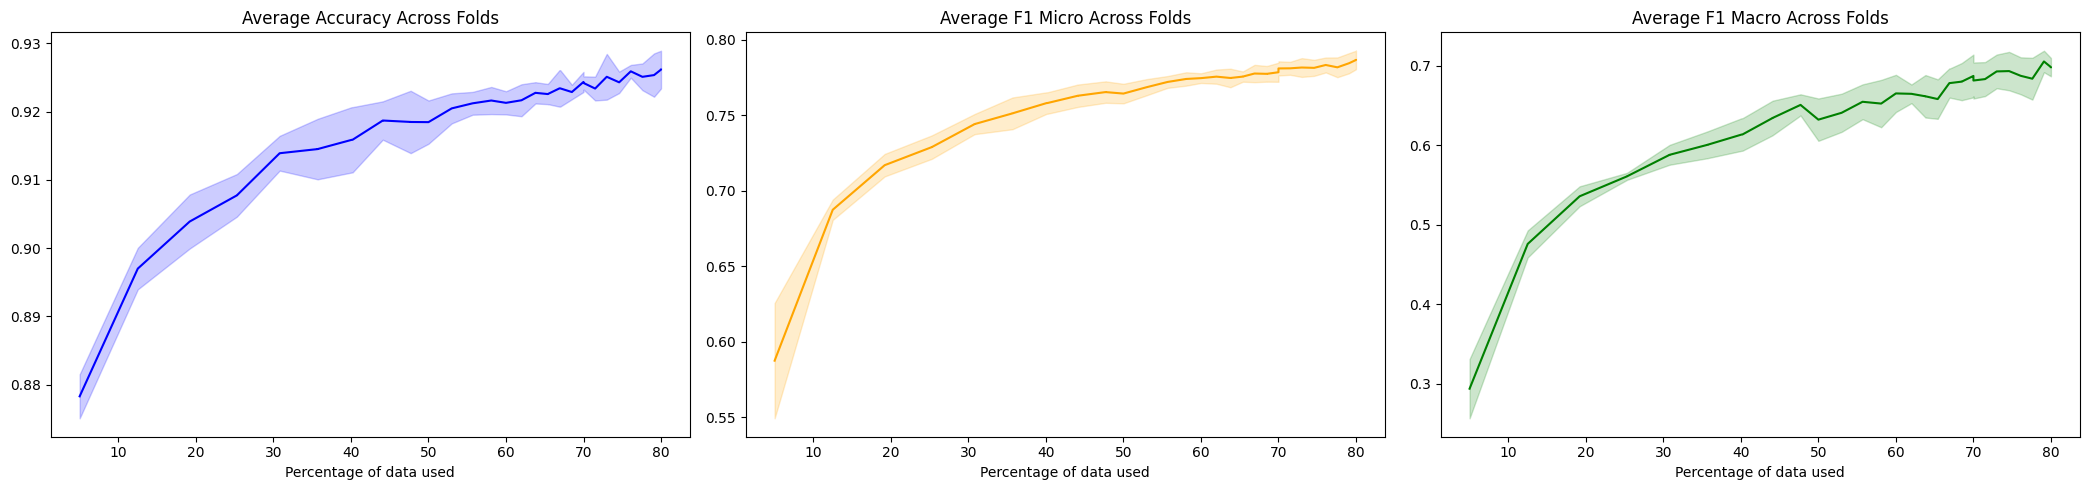

In [21]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(N_SPLITS):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

plt.tight_layout()
plt.show()

for i in range(N_SPLITS):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)